In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import datasets
sensorA_System1 = pd.read_csv("../../../RawData/System1_SensorA.csv")
sensorA_System2 = pd.read_csv("../../../RawData/System2_SensorA.csv")
sensorB_System1 = pd.read_csv("../../../RawData/System1_SensorB.csv")
sensorB_System2 = pd.read_csv("../../../RawData/System2_SensorB.csv")
keyByTestID = pd.read_csv("../../../RawData/Key by TestID.csv")

In [3]:
# Transpose dataset to make columns as timestamps and rows as tests
A1_transposed = sensorA_System1.T.reset_index()
A1_transposed.columns = A1_transposed.iloc[0]
A1_transposed.rename(columns={A1_transposed.columns[0]: 'TestID'}, inplace=True)
A1_transposed = A1_transposed.drop(0)
A1_transposed['TestID'] = A1_transposed['TestID'].astype(int)

A2_transposed = sensorA_System2.T.reset_index()
A2_transposed.columns = A2_transposed.iloc[0]
A2_transposed.rename(columns={A2_transposed.columns[0]: 'TestID'}, inplace=True)
A2_transposed = A2_transposed.drop(0)
A2_transposed['TestID'] = A2_transposed['TestID'].astype(int)

B1_transposed = sensorB_System1.T.reset_index()
B1_transposed.columns = B1_transposed.iloc[0]
B1_transposed.rename(columns={B1_transposed.columns[0]: 'TestID'}, inplace=True)
B1_transposed = B1_transposed.drop(0)
B1_transposed['TestID'] = B1_transposed['TestID'].astype(int)

B2_transposed = sensorB_System2.T.reset_index()
B2_transposed.columns = B2_transposed.iloc[0]
B2_transposed.rename(columns={B2_transposed.columns[0]: 'TestID'}, inplace=True)
B2_transposed = B2_transposed.drop(0)
B2_transposed['TestID'] = B2_transposed['TestID'].astype(int)

In [4]:
# Merge dataset with keyByTestID and delete unmatched tests
keyByTestID['TestID'] = keyByTestID['TestID'].astype(int)
keyByTestID['System'] = keyByTestID['System'].astype(str)
keyByTestID = keyByTestID[keyByTestID['ReturnCode'].isin(['Success','UnderReportableRange'])]

A1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] == 'System 1')]
A1_Merged = pd.merge(A1_keyByTestID,A1_transposed,how='inner', on=['TestID'])
A1_transposed = A1_transposed[A1_transposed['TestID'].isin(A1_Merged['TestID'])]

A2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor A') & (keyByTestID['System'] != 'System 1')]
A2_Merged = pd.merge(A2_keyByTestID,A2_transposed,how='inner', on=['TestID'])
A2_transposed = A2_transposed[A2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorA_System1 = sensorA_System1.loc[:, sensorA_System1.columns.isin(A1_Merged['TestID'].astype(str))]
sensorA_System2 = sensorA_System2.loc[:, sensorA_System2.columns.isin(A2_Merged['TestID'].astype(str))]


B1_keyByTestID = keyByTestID[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] == 'System 1')]
B1_Merged = pd.merge(B1_keyByTestID,B1_transposed,how='inner', on=['TestID'])
B1_transposed = B1_transposed[B1_transposed['TestID'].isin(B1_Merged['TestID'])]

B2_keyByTestID = keyByTestID.loc[(keyByTestID['Sensor'] == 'Sensor B') & (keyByTestID['System'] != 'System 1')]
B2_Merged = pd.merge(B2_keyByTestID,B2_transposed,how='inner', on=['TestID'])
B1_transposed = B2_transposed[B2_transposed['TestID'].isin(A2_Merged['TestID'])]

sensorB_System1 = sensorB_System1.loc[:, sensorB_System1.columns.isin(B1_Merged['TestID'].astype(str))]
sensorB_System2 = sensorB_System2.loc[:, sensorB_System2.columns.isin(B2_Merged['TestID'].astype(str))]

In [5]:
# Match window values of Sensor A for each test
calDelimit = 11
cal_window_size = 8
sampleDelimit = 15
sample_window_size = 5

# Define a function to calculate window start and end values
def calculate_window_values(bubble_start, sample_start, calDelimit, cal_window_size, sampleDelimit, sample_window_size):
    cal_window_start = bubble_start - calDelimit
    cal_window_end = cal_window_start + cal_window_size
    sample_window_start = sample_start + sampleDelimit
    sample_window_end = sample_window_start + sample_window_size
    return cal_window_start, cal_window_end, sample_window_start, sample_window_end

# For sensor A in system 1
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start = A1_Merged['BubbleDetectTime'],
                                                                                                   sample_start = A1_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size
                                                                                                   )
A1_Merged['cal_window_start']=cal_window_start
A1_Merged['cal_window_end']=cal_window_end
A1_Merged['sample_window_start']=sample_window_start
A1_Merged['sample_window_end']=sample_window_end

# For sensor A in system 2
cal_window_start, cal_window_end, sample_window_start, sample_window_end = calculate_window_values(bubble_start=A2_Merged['BubbleDetectTime'],
                                                                                                   sample_start=A2_Merged['SampleDetectTime'],
                                                                                                   calDelimit = calDelimit,
                                                                                                   cal_window_size = cal_window_size,
                                                                                                   sampleDelimit = sampleDelimit,
                                                                                                   sample_window_size = sample_window_size)
A2_Merged['cal_window_start']=cal_window_start
A2_Merged['cal_window_end']=cal_window_end
A2_Merged['sample_window_start']=sample_window_start
A2_Merged['sample_window_end']=sample_window_end

In [6]:
# Match window values of Sensor B for each test
calDelimit = 20
cal_window_size = 18
sampleDelimit_blood = 24
sampleDelimit_aqueous = 30
sample_window_size = 4

# For sensor B in system 1, blood and aqueous
B1_Merged['cal_window_start'], B1_Merged['cal_window_end'], \
B1_Merged['sample_window_start'], B1_Merged['sample_window_end'] = zip(*B1_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

# For sensor B in system 2, blood and aqueous
B2_Merged['cal_window_start'], B2_Merged['cal_window_end'], \
B2_Merged['sample_window_start'], B2_Merged['sample_window_end'] = zip(*B2_Merged.apply(
    lambda row: calculate_window_values(
        bubble_start=row['BubbleDetectTime'],
        sample_start=row['SampleDetectTime'],
        calDelimit=calDelimit,
        cal_window_size=cal_window_size,
        sampleDelimit=sampleDelimit_aqueous if row['FluidType'].startswith('Eurotrol') else sampleDelimit_blood,
        sample_window_size=sample_window_size
    ),
    axis=1
))

In [7]:
# Define a function to extract window data of each test
def calculate_window_data(row):
    cal_start_time = row['cal_window_start']
    cal_end_time = row['cal_window_end']
    sample_start_time = row['sample_window_start']
    sample_end_time = row['sample_window_end']
    timestamps = row.index[18:-4].values.astype(float)
    cal_window = timestamps[(timestamps >= cal_start_time) & (timestamps <= cal_end_time)]
    sample_window = timestamps[(timestamps >= sample_start_time) & (timestamps <= sample_end_time)]
    return row[cal_window],row[sample_window]

# extract window data for sensor A in system 1
A1_cal_window = []
A1_sample_window = []
for i in range(len(A1_Merged)):
    cal_window, sample_window = calculate_window_data(A1_Merged.iloc[i, :])
    A1_cal_window.append(cal_window.values)
    A1_sample_window.append(sample_window.values)
A1_cal_window = pd.DataFrame(A1_cal_window)
A1_sample_window = pd.DataFrame(A1_sample_window)
A1_cal_window['TestID'] = A1_sample_window['TestID'] = A1_Merged['TestID']
A1_sample_window.set_index('TestID',inplace=True)
A1_cal_window.set_index('TestID',inplace=True)
A1_cal_window.dropna(inplace=True)
A1_sample_window.dropna(inplace=True)

# extract window data for sensor A in system 2
A2_cal_window = []
A2_sample_window = []
for i in range(len(A2_Merged)):
    cal_window, sample_window = calculate_window_data(A2_Merged.iloc[i, :])
    A2_cal_window.append(cal_window.values)
    A2_sample_window.append(sample_window.values)
A2_cal_window = pd.DataFrame(A2_cal_window)
A2_sample_window = pd.DataFrame(A2_sample_window)
A2_cal_window['TestID'] = A2_sample_window['TestID'] = A2_Merged['TestID']
A2_sample_window.set_index('TestID',inplace=True)
A2_cal_window.set_index('TestID',inplace=True)
A2_cal_window.dropna(inplace=True)
A2_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 1
B1_cal_window = []
B1_sample_window = []
for i in range(len(B1_Merged)):
    cal_window, sample_window = calculate_window_data(B1_Merged.iloc[i, :])
    B1_cal_window.append(cal_window.values)
    B1_sample_window.append(sample_window.values)
B1_cal_window = pd.DataFrame(B1_cal_window)
B1_sample_window = pd.DataFrame(B1_sample_window)
B1_cal_window['TestID'] = B1_sample_window['TestID'] = B1_Merged['TestID']
B1_sample_window.set_index('TestID',inplace=True)
B1_cal_window.set_index('TestID',inplace=True)
B1_cal_window.dropna(inplace=True)
B1_sample_window.dropna(inplace=True)

# extract window data for sensor B in system 2
B2_cal_window = []
B2_sample_window = []
for i in range(len(B2_Merged)):
    cal_window, sample_window = calculate_window_data(B2_Merged.iloc[i, :])
    B2_cal_window.append(cal_window.values)
    B2_sample_window.append(sample_window.values)
B2_cal_window = pd.DataFrame(B2_cal_window)
B2_sample_window = pd.DataFrame(B2_sample_window)
B2_cal_window['TestID'] = B2_sample_window['TestID'] = B2_Merged['TestID']
B2_sample_window.set_index('TestID',inplace=True)
B2_cal_window.set_index('TestID',inplace=True)
B2_cal_window.dropna(inplace=True)
B2_sample_window.dropna(inplace=True)


In [8]:
A1_Merged = A1_Merged[A1_Merged['TestID'].isin(A1_sample_window.index)]
A1_Merged = A1_Merged[A1_Merged['TestID'].isin(A1_cal_window.index)]
A2_Merged = A2_Merged[A2_Merged['TestID'].isin(A2_sample_window.index)]
A2_Merged = A2_Merged[A2_Merged['TestID'].isin(A2_cal_window.index)]
B1_Merged = B1_Merged[B1_Merged['TestID'].isin(B1_sample_window.index)]
B1_Merged = B1_Merged[B1_Merged['TestID'].isin(B1_cal_window.index)]
B2_Merged = B2_Merged[B2_Merged['TestID'].isin(B2_sample_window.index)]
B2_Merged = B2_Merged[B2_Merged['TestID'].isin(B2_cal_window.index)]

# Check missing values in window data
rows_with_missing_values = A2_cal_window[A2_cal_window.isnull().any(axis=1)].index
print(rows_with_missing_values)
keyByTestID[keyByTestID['TestID'].isin(rows_with_missing_values)]
A2_Merged[A2_Merged['TestID'].isin(rows_with_missing_values)]

Int64Index([], dtype='int64', name='TestID')


Empty DataFrame
Columns: [TestID, FluidType, DateTime, Lot, CardNumber, AgeOfCardInDaysAtTimeOfTest, ReaderSerialNumber, SampleDetectTime, BubbleDetectTime, System, Sensor, AmbientTemperature, Fluid Temperature, CardReturnCode, ReturnCode, Results Error Code, Device Return Code, Bge Test ReturnCode, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4, 5.6, 5.8, 6.0, 6.2, 6.4, 6.6, 6.8, 7.0, 7.2, 7.4, 7.6, 7.8, 8.0, 8.2, 8.4, 8.6, 8.8, 9.0, 9.2, 9.4, 9.6, 9.8, 10.0, 10.2, 10.4, 10.6, 10.8, 11.0, 11.2, 11.4, 11.6, 11.8, 12.0, 12.2, 12.4, 12.6, 12.8, 13.0, 13.2, 13.4, 13.6, 13.8, 14.0, 14.2, 14.4, 14.6, 14.8, 15.0, 15.2, 15.4, 15.6, 15.8, 16.0, 16.2, 16.4, ...]
Index: []

[0 rows x 1323 columns]

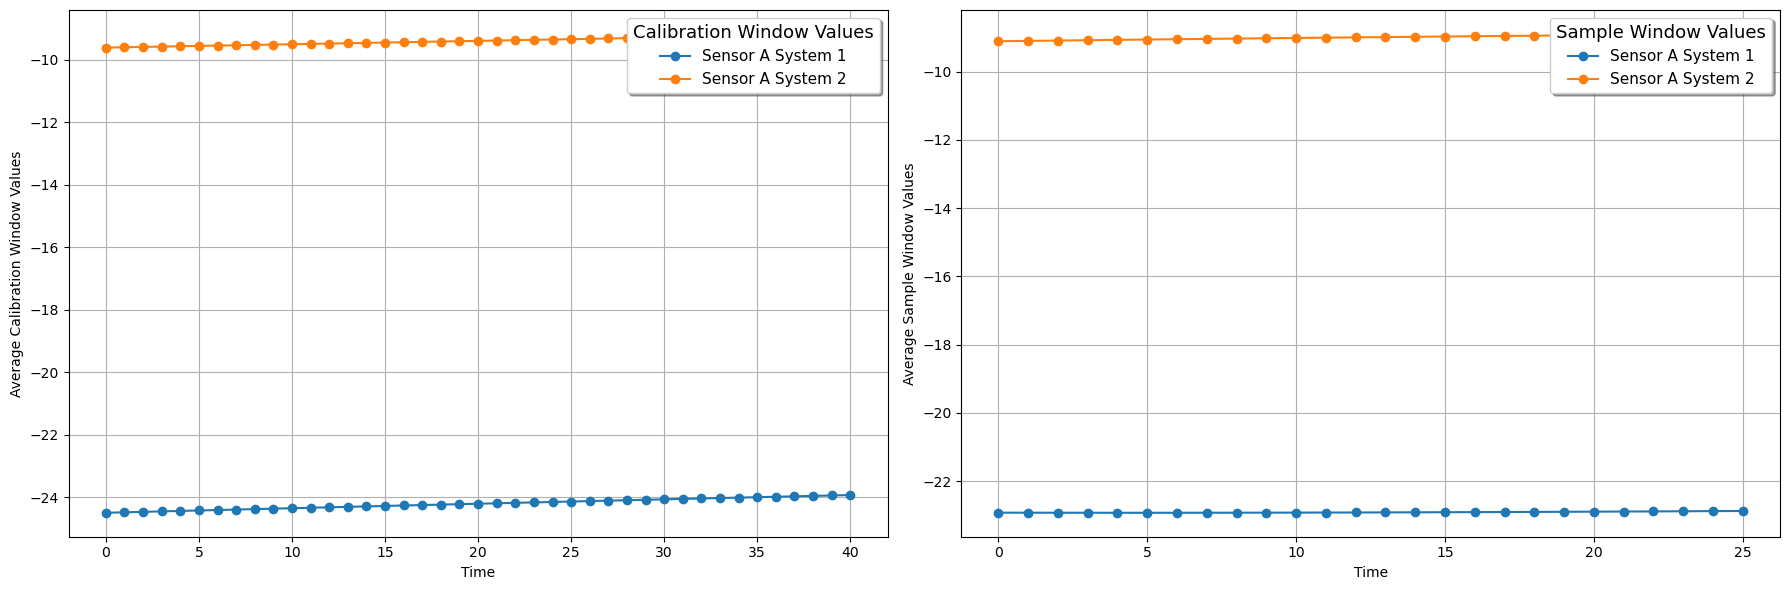

In [9]:
# Plot the window for sensor A
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor A
axs[0].plot(A1_cal_window.columns, A1_cal_window.mean(), marker='o', linestyle='-', label='Sensor A System 1')
# axs[0].fill_between(A1_cal_window.columns.to_numpy(), A1_cal_window.mean() - A1_cal_window.std(), A1_cal_window.mean() - A1_cal_window.std(), color='blue', alpha=0.3)
axs[0].plot(A2_cal_window.columns, A2_cal_window.mean(), marker='o', linestyle='-', label='Sensor A System 2')
# axs[0].fill_between(A2_cal_window.columns.to_numpy(), A2_cal_window.mean() - A2_cal_window.std(), A2_cal_window.mean() + A2_cal_window.std(), color='red', alpha=0.3)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor A
axs[1].plot(A1_sample_window.columns, A1_sample_window.mean(), marker='o', linestyle='-', label='Sensor A System 1')
axs[1].plot(A2_sample_window.columns, A2_sample_window.mean(), marker='o', linestyle='-', label='Sensor A System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()


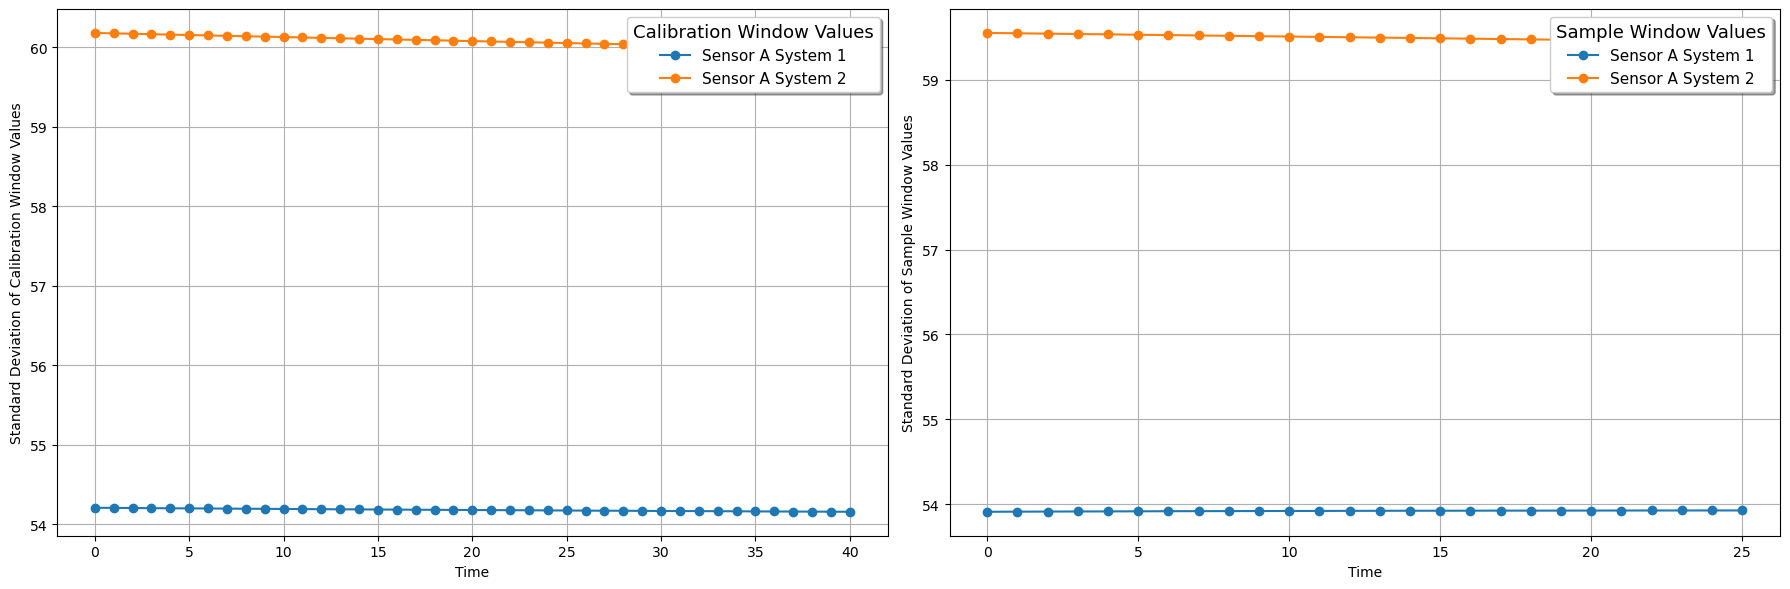

In [10]:
# Plot the window for sensor A
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor A
axs[0].plot(A1_cal_window.columns, A1_cal_window.std(), marker='o', linestyle='-', label='Sensor A System 1')
axs[0].plot(A2_cal_window.columns, A2_cal_window.std(), marker='o', linestyle='-', label='Sensor A System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Standard Deviation of Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor A
axs[1].plot(A1_sample_window.columns, A1_sample_window.std(), marker='o', linestyle='-', label='Sensor A System 1')
axs[1].plot(A2_sample_window.columns, A2_sample_window.std(), marker='o', linestyle='-', label='Sensor A System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Standard Deviation of Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

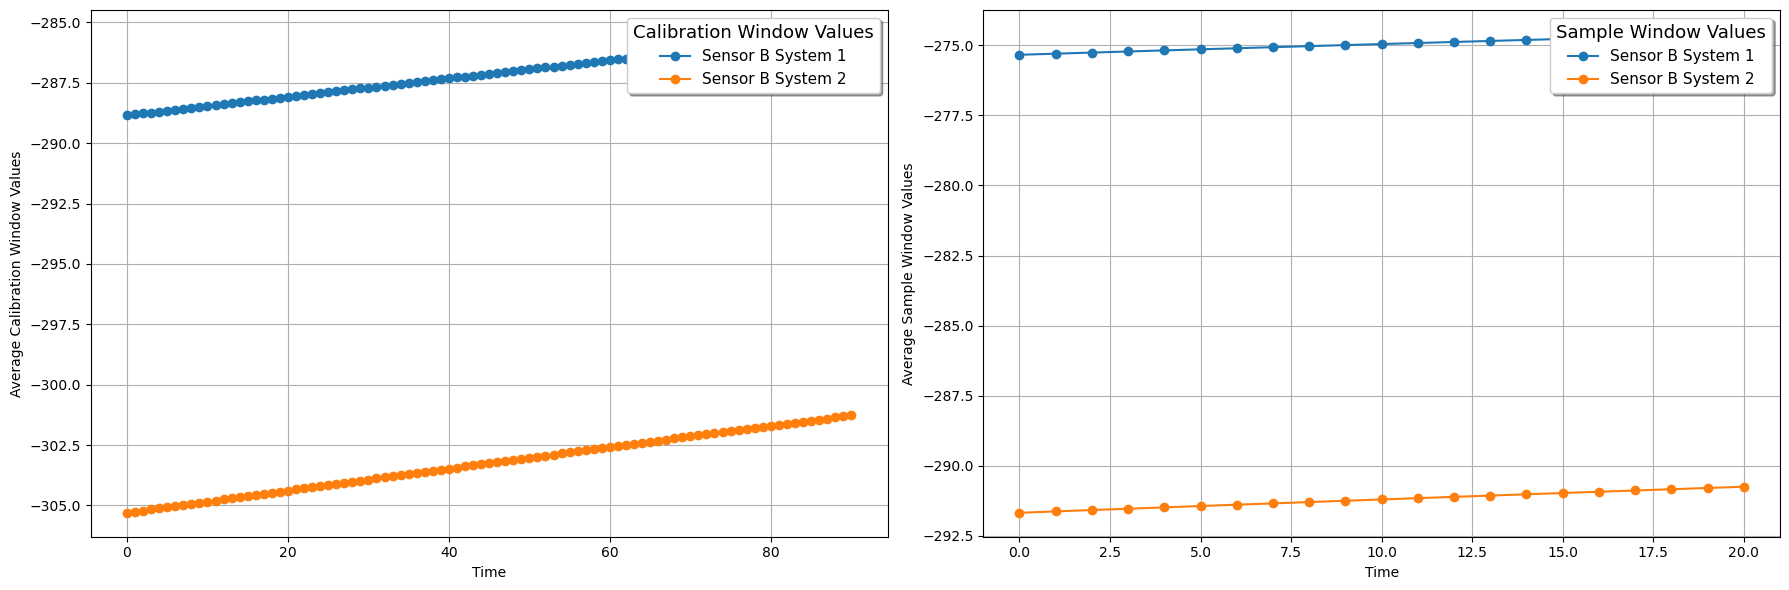

In [11]:
# Plot the window for sensor B
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor B
axs[0].plot(B1_cal_window.columns, B1_cal_window.mean(), marker='o', linestyle='-', label='Sensor B System 1')
axs[0].plot(B2_cal_window.columns, B2_cal_window.mean(), marker='o', linestyle='-', label='Sensor B System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Average Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor B
axs[1].plot(B1_sample_window.columns, B1_sample_window.mean(), marker='o', linestyle='-', label='Sensor B System 1')
axs[1].plot(B2_sample_window.columns, B2_sample_window.mean(), marker='o', linestyle='-', label='Sensor B System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Average Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

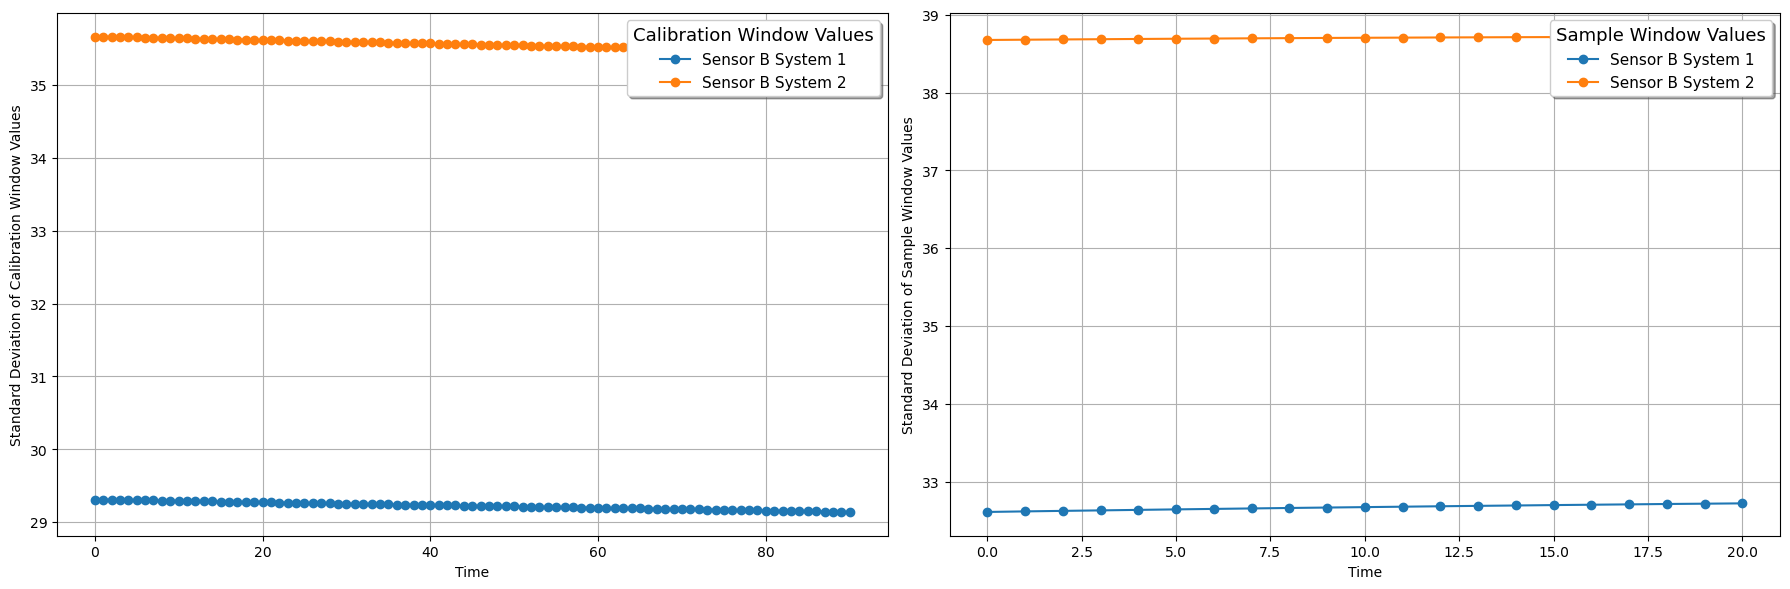

In [12]:
# Plot the window for sensor B
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot the first window for sensor B
axs[0].plot(B1_cal_window.columns, B1_cal_window.std(), marker='o', linestyle='-', label='Sensor B System 1')
axs[0].plot(B2_cal_window.columns, B2_cal_window.std(), marker='o', linestyle='-', label='Sensor B System 2')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Standard Deviation of Calibration Window Values')
axs[0].legend(title='Calibration Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[0].grid(True)

# Plot the second window for sensor B
axs[1].plot(B1_sample_window.columns, B1_sample_window.std(), marker='o', linestyle='-', label='Sensor B System 1')
axs[1].plot(B2_sample_window.columns, B2_sample_window.std(), marker='o', linestyle='-', label='Sensor B System 2')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Standard Deviation of Sample Window Values')
axs[1].legend(title='Sample Window Values', title_fontsize='13', fontsize='11', loc='upper right', frameon=True, shadow=True, fancybox=True)
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [13]:
# Calculate metrics of average window data for sensor A
cal_metrics=[[A1_cal_window.mean().mean(),A2_cal_window.mean().mean()],
            [A1_cal_window.mean().std(),A2_cal_window.mean().std()],
            [(A1_cal_window.mean().max()-A1_cal_window.mean().min())/A1_cal_window.mean().mean(),
            (A2_cal_window.mean().max()-A2_cal_window.mean().min())/A2_cal_window.mean().mean()]]
cal_metrics_summary = pd.DataFrame(cal_metrics, columns=['A1-cal','A2-cal'], index=['mean','sd','slope'])
print(cal_metrics_summary)
print()
sample_metrics=[[A1_sample_window.mean().mean(),A2_sample_window.mean().mean()],
            [A1_sample_window.mean().std(),A2_sample_window.mean().std()],
            [(A1_sample_window.mean().max()-A1_sample_window.mean().min())/A1_sample_window.mean().mean(),
            (A2_sample_window.mean().max()-A2_sample_window.mean().min())/A2_sample_window.mean().mean()]]
sample_metrics_summary = pd.DataFrame(sample_metrics, columns=['A1-sample','A2-sample'], index=['mean','sd','slope'])
print(sample_metrics_summary)

          A1-cal    A2-cal
mean  -24.203128 -9.393469
sd      0.169811  0.130269
slope  -0.023429 -0.046404

       A1-sample  A2-sample
mean  -22.912249  -8.993571
sd      0.017009   0.065522
slope  -0.002295  -0.023797


In [14]:
# Calculate metrics of average window data for sensor B
cal_metrics=[[B1_cal_window.mean().mean(),B2_cal_window.mean().mean()],
            [B1_cal_window.mean().std(),B2_cal_window.mean().std()],
            [(B1_cal_window.mean().max()-B1_cal_window.mean().min())/B1_cal_window.mean().mean(),
            (B2_cal_window.mean().max()-B2_cal_window.mean().min())/B2_cal_window.mean().mean()]]
cal_metrics_summary = pd.DataFrame(cal_metrics, columns=['B1-cal','B2-cal'], index=['mean','sd','slope'])
print(cal_metrics_summary)
print()
sample_metrics=[[B1_sample_window.mean().mean(),B2_sample_window.mean().mean()],
            [B1_sample_window.mean().std(),B2_sample_window.mean().std()],
            [(B1_sample_window.mean().max()-B1_sample_window.mean().min())/B1_sample_window.mean().mean(),
            (B2_sample_window.mean().max()-B2_sample_window.mean().min())/B2_sample_window.mean().mean()]]
sample_metrics_summary = pd.DataFrame(sample_metrics, columns=['B1-sample','B2-sample'], index=['mean','sd','slope'])
print(sample_metrics_summary)

           B1-cal      B2-cal
mean  -287.140933 -303.261507
sd       0.990252    1.184286
slope   -0.011728   -0.013301

        B1-sample   B2-sample
mean  -274.959814 -291.207365
sd       0.230525    0.288276
slope   -0.002703   -0.003192


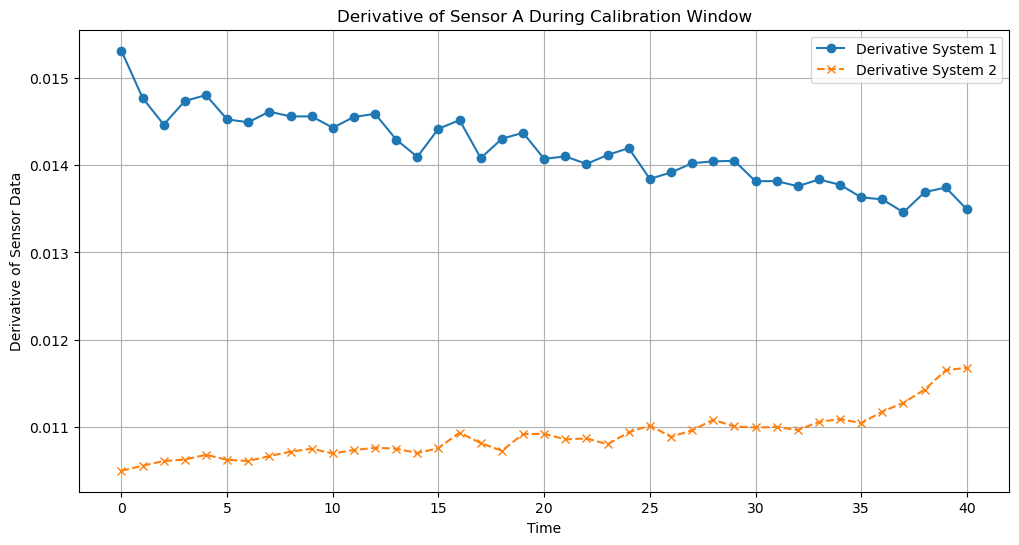

In [15]:
# Calibration window derivative trend for sensor A
# Calculate the derivative of sensor data
A1_cal_window_derivative = np.gradient(A1_cal_window.mean(), A1_cal_window.columns)
A2_cal_window_derivative = np.gradient(A2_cal_window.mean(), A2_cal_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(A1_cal_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(A2_cal_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor A During Calibration Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

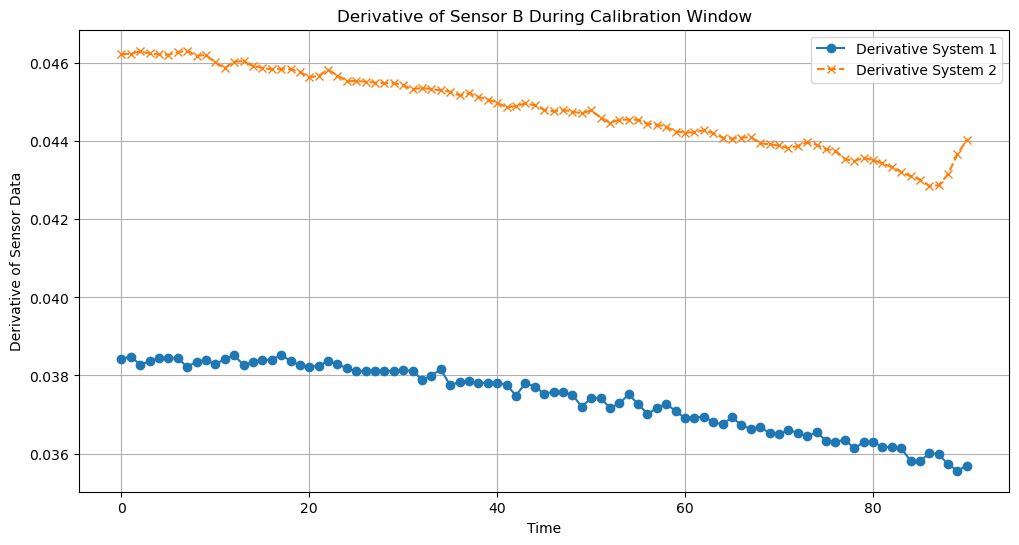

In [16]:
# Calibration window derivative trend for sensor B
# Calculate the derivative of sensor data
B1_cal_window_derivative = np.gradient(B1_cal_window.mean(), B1_cal_window.columns)
B2_cal_window_derivative = np.gradient(B2_cal_window.mean(), B2_cal_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(B1_cal_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(B2_cal_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor B During Calibration Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

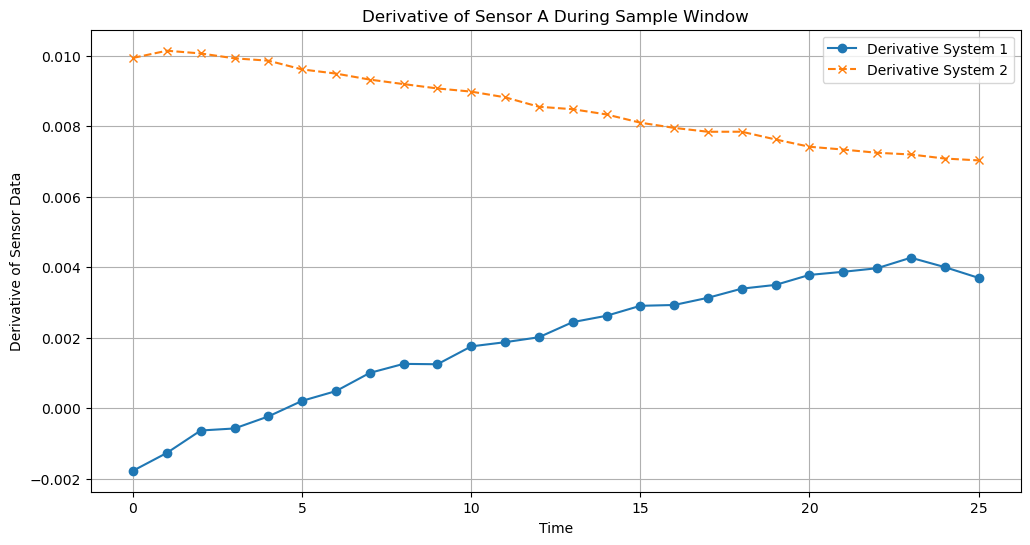

In [17]:
# Sample window derivative trend for sensor A
# Calculate the derivative of sensor data
A1_sample_window_derivative = np.gradient(A1_sample_window.mean(), A1_sample_window.columns)
A2_sample_window_derivative = np.gradient(A2_sample_window.mean(), A2_sample_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(A1_sample_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(A2_sample_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor A During Sample Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

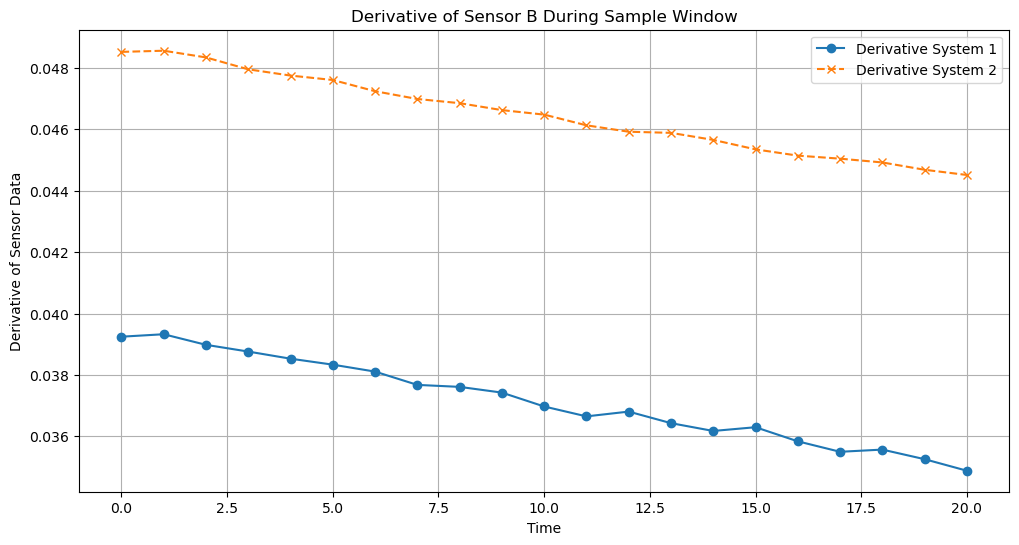

In [18]:
# Sample window derivative trend for sensor B
# Calculate the derivative of sensor data
B1_sample_window_derivative = np.gradient(B1_sample_window.mean(), B1_sample_window.columns)
B2_sample_window_derivative = np.gradient(B2_sample_window.mean(), B2_sample_window.columns)

# Plotting the derivatives
plt.figure(figsize=(12, 6))
plt.plot(B1_sample_window_derivative, label='Derivative System 1', marker='o', linestyle='-')
plt.plot(B2_sample_window_derivative, label='Derivative System 2', marker='x', linestyle='--')

plt.title('Derivative of Sensor B During Sample Window')
plt.xlabel('Time')
plt.ylabel('Derivative of Sensor Data')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import altair as alt
from altair_data_server import data_server
alt.data_transformers.enable('vegafusion')
A_Merged = pd.concat([A1_Merged, A2_Merged], ignore_index=True)
A_Merged = A_Merged.assign(System=np.where(A_Merged.index < len(A1_Merged), 'System1', 'System2'))
df = A_Merged[['FluidType','AgeOfCardInDaysAtTimeOfTest','AmbientTemperature','System']]
df['Type'] = df['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
cardage = alt.Chart(df).mark_boxplot().encode(
    y=alt.Y('AgeOfCardInDaysAtTimeOfTest:Q', title='Card Age'),
    x='System'
    ).properties(width=200, height=200)

temperature = alt.Chart(df).mark_boxplot().encode(
    y=alt.Y('AmbientTemperature:Q',title='Temperature'),
    x='System'
).properties(width=200, height=200)

FluidType = alt.Chart(df).mark_bar().encode(
    x='System:N',
    y='count()',
    color='Type'
).properties(width=200, height=200)

cardage | temperature | FluidType

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_22194/2752349317.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Type'] = df['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')


alt.HConcatChart(...)

### K-means clustering by sensor values

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Merge system 1 and 2
A_cal_window = pd.concat([A1_cal_window, A2_cal_window])
A_sample_window = pd.concat([A1_sample_window, A2_sample_window])
B_cal_window = pd.concat([B1_cal_window, B2_cal_window])
B_sample_window = pd.concat([B1_sample_window, B2_sample_window])

# Technique 1: Normalize data
A_cal_window_normalized = StandardScaler().fit_transform(A_cal_window)
A_sample_window_normalized = StandardScaler().fit_transform(A_sample_window)
B_cal_window_normalized = StandardScaler().fit_transform(B_cal_window)
B_sample_window_normalized = StandardScaler().fit_transform(B_sample_window)

# Technique 2: Put the beginning of all sensor data at the same value (zero)
A_cal_window_zero = A_cal_window.iloc[:, 1:].sub(A_cal_window.iloc[:, 1], axis=0)
A_sample_window_zero = A_sample_window.iloc[:, 1:].sub(A_sample_window.iloc[:, 1], axis=0)
B_cal_window_zero = B_cal_window.iloc[:, 1:].sub(B_cal_window.iloc[:, 1], axis=0)
B_sample_window_zero = B_sample_window.iloc[:, 1:].sub(B_sample_window.iloc[:, 1], axis=0)


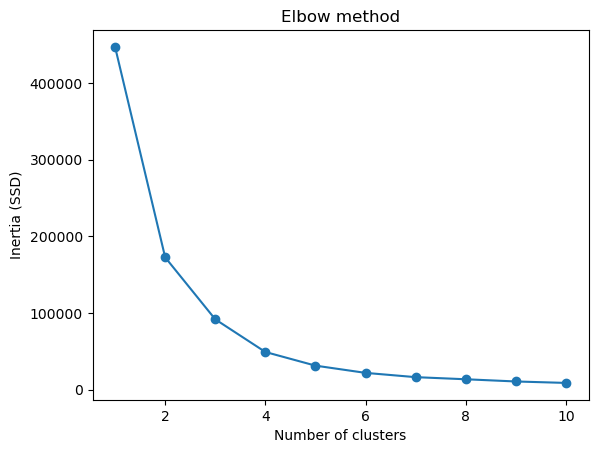

In [21]:
# sensorA calibration window
inertias_cal_A = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(A_cal_window_normalized)
    inertias_cal_A.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_cal_A, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

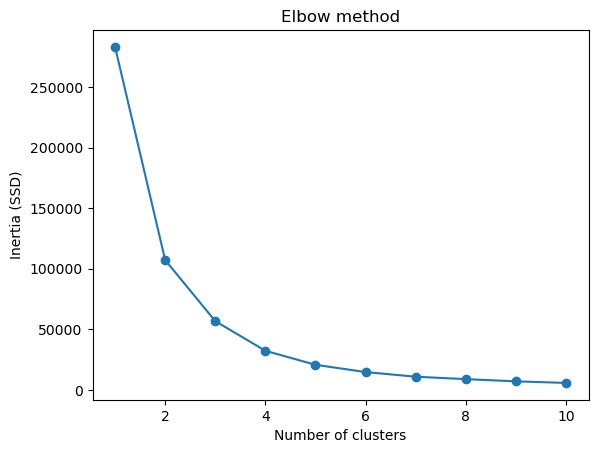

In [22]:
# sensorA sample window
inertias_sample_A = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(A_sample_window_normalized)
    inertias_sample_A.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_sample_A, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

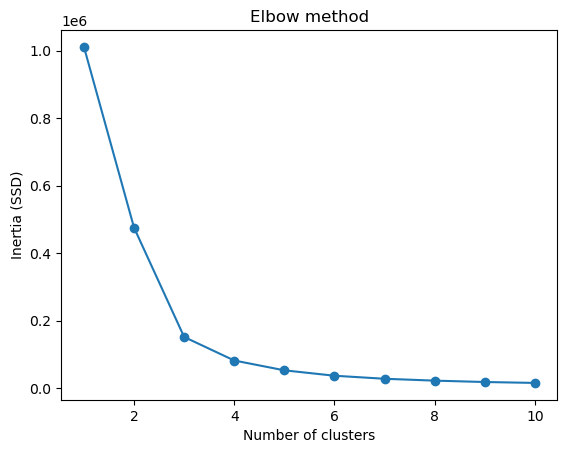

In [23]:
# sensorB calibration window
inertias_cal_B = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(B_cal_window_normalized)
    inertias_cal_B.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_cal_B, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

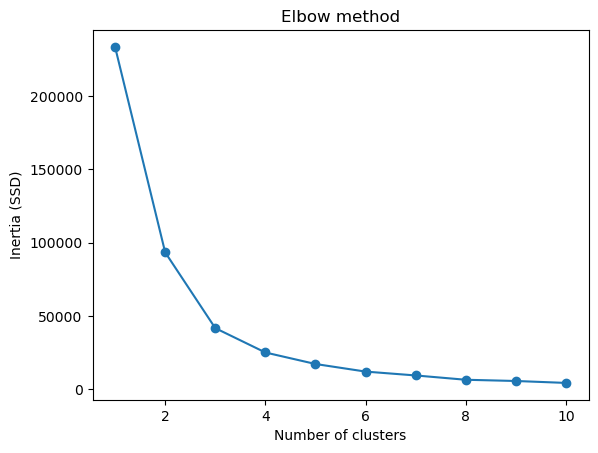

In [24]:
# sensorB sample window
inertias_sample_B = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i).fit(B_sample_window_normalized)
    inertias_sample_B.append(kmeans.inertia_)

plt.plot(range(1,11), inertias_sample_B, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia (SSD)')
plt.show()

In [25]:
n_clusters = 3

#### Euclidean K-means on normalized data

In [26]:
# Sensor A Cal Window
model_euclidean= KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_cal_window_normalized)

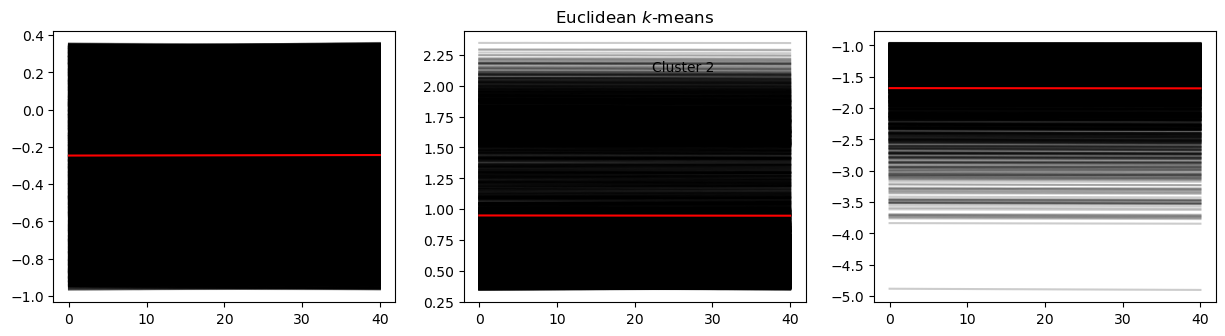

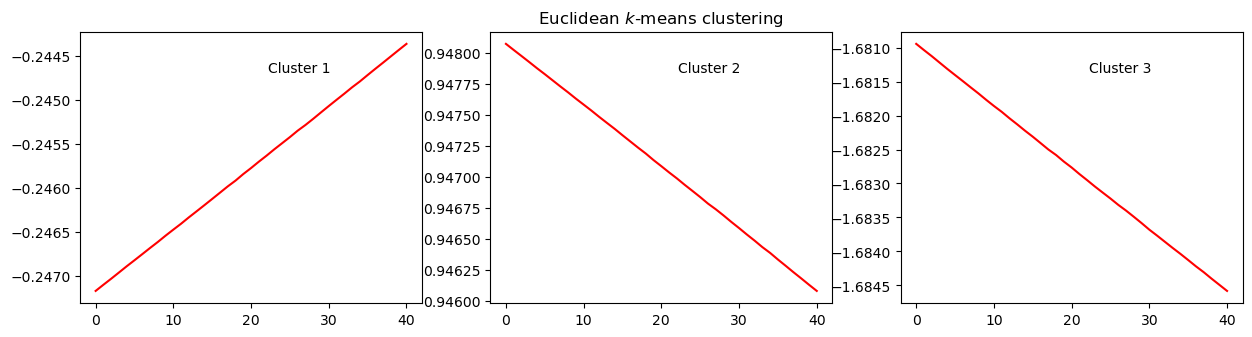

In [27]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in A_cal_window_normalized[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [28]:
# sensor A sample window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_sample_window_normalized)

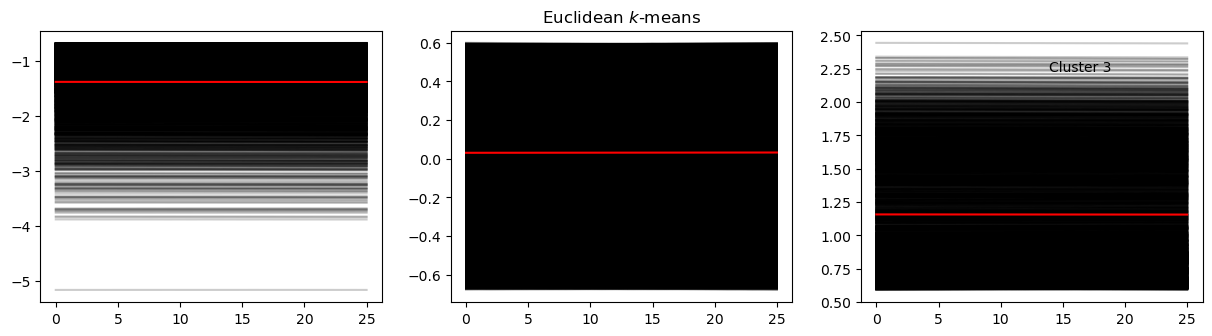

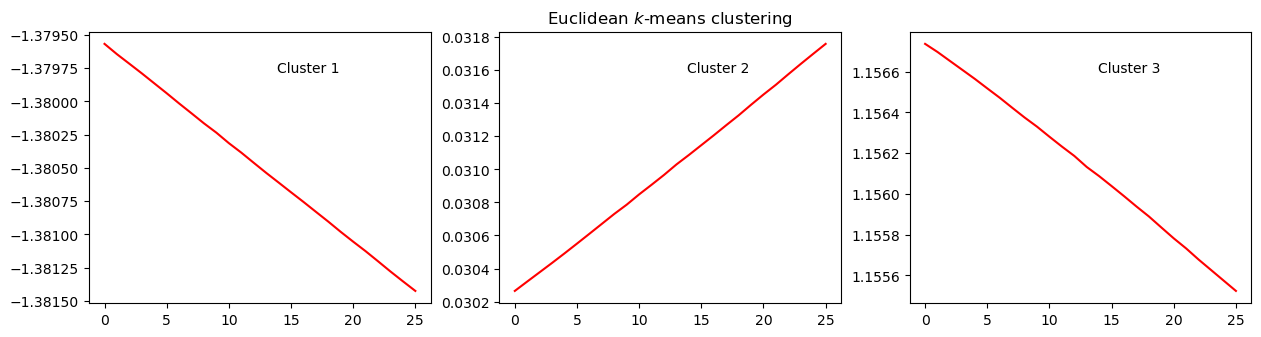

In [29]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in A_sample_window_normalized[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [30]:
# sensor B cal window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_cal_window_normalized)

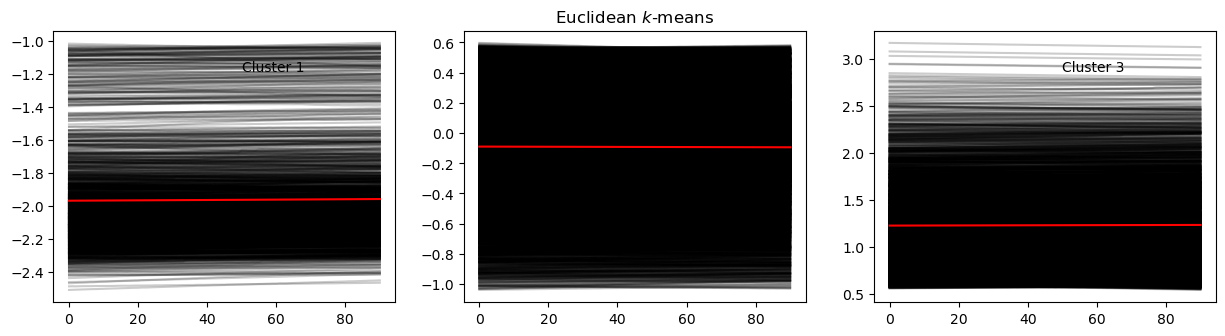

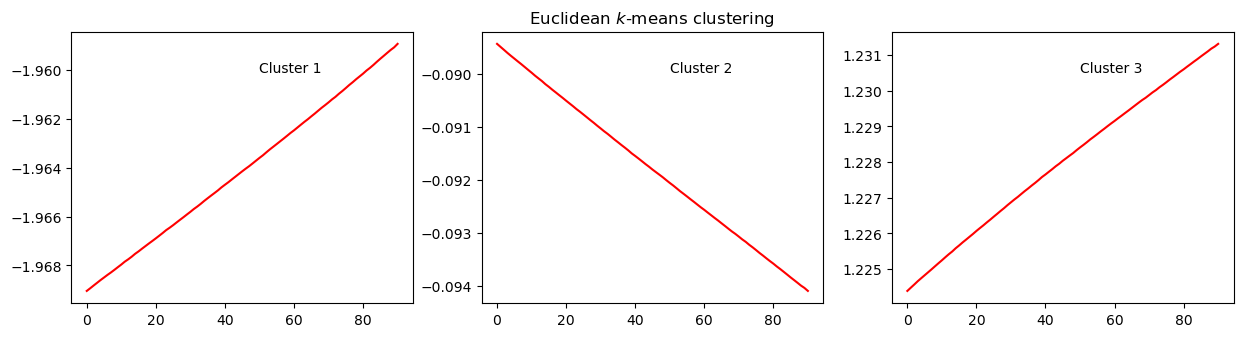

In [31]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in B_cal_window_normalized[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [32]:
# sensor B sample window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_sample_window_normalized)

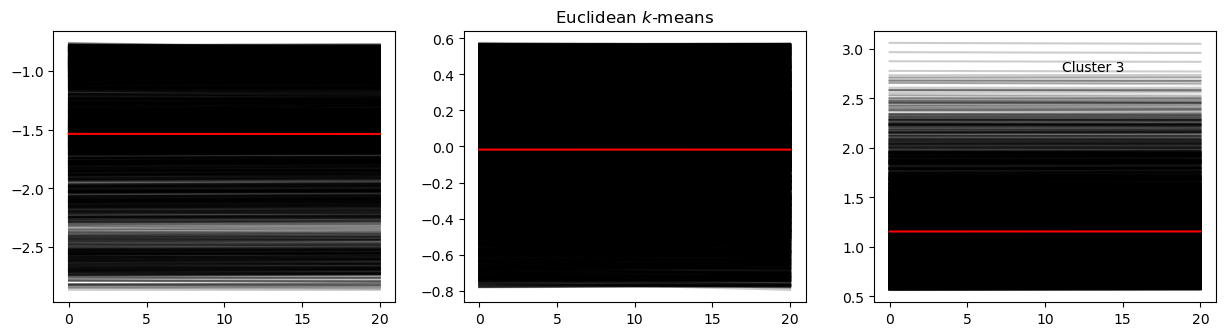

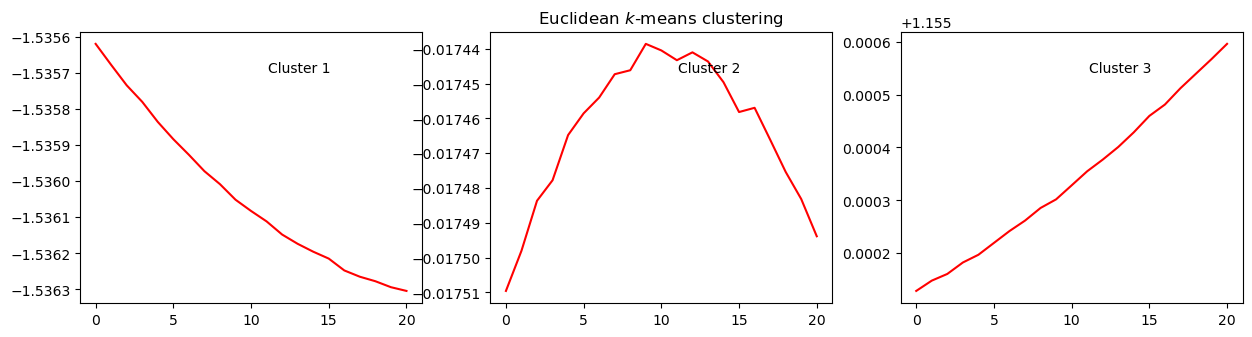

In [33]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in B_sample_window_normalized[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

#### DTW K-means on normalized data

In [34]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.metrics import dtw

# Sensor A cal window
data = A_cal_window_normalized.reshape(A_cal_window_normalized.shape[0], A_cal_window_normalized.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

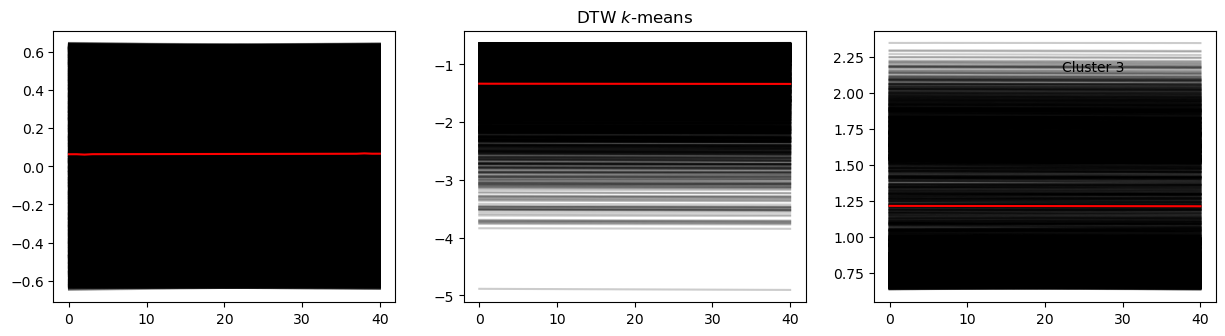

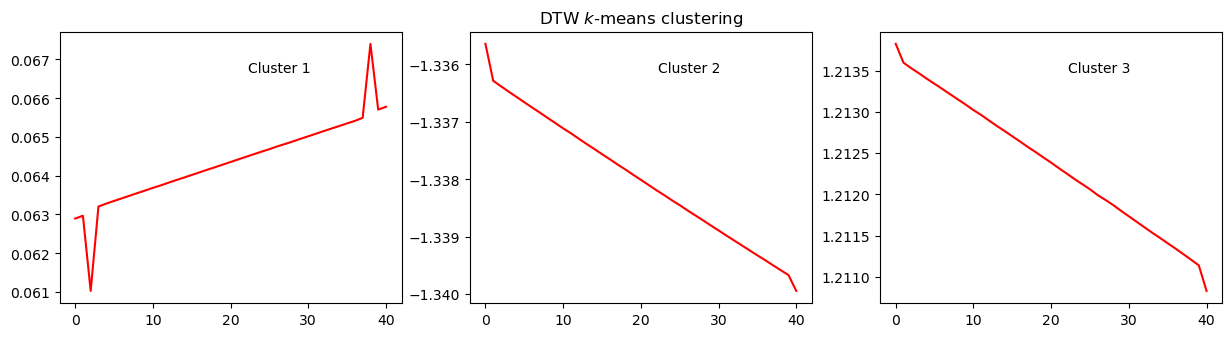

In [35]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [36]:
# Sensor A sample window
data = A_sample_window_normalized.reshape(A_sample_window_normalized.shape[0], A_sample_window_normalized.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

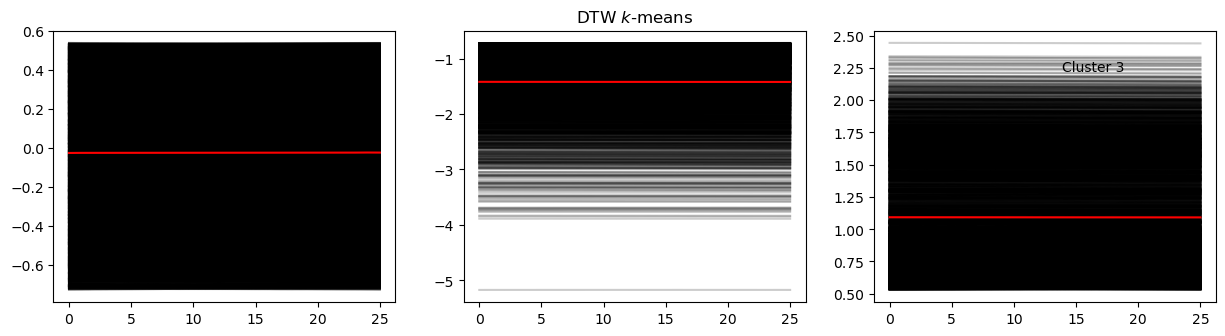

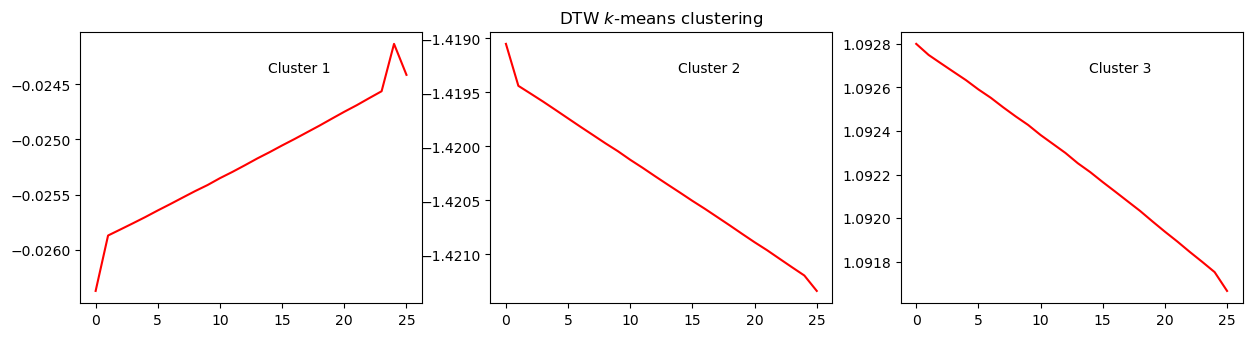

In [37]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [38]:
# Sensor B cal window
data = B_cal_window_normalized.reshape(B_cal_window_normalized.shape[0], B_cal_window_normalized.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

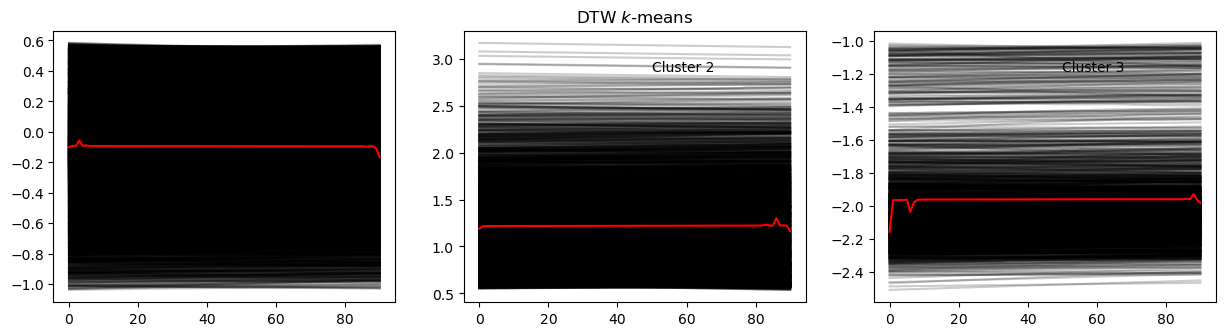

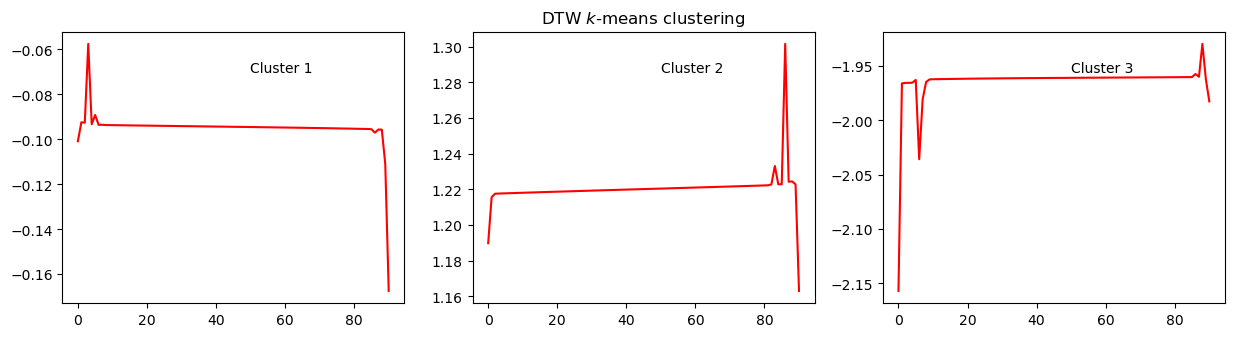

In [39]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [40]:
# Sensor B sample window
data = B_sample_window_normalized.reshape(B_sample_window_normalized.shape[0], B_sample_window_normalized.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

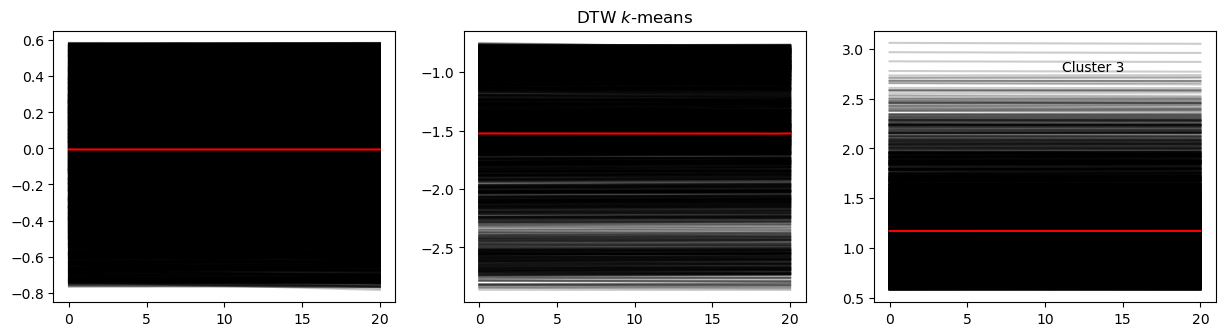

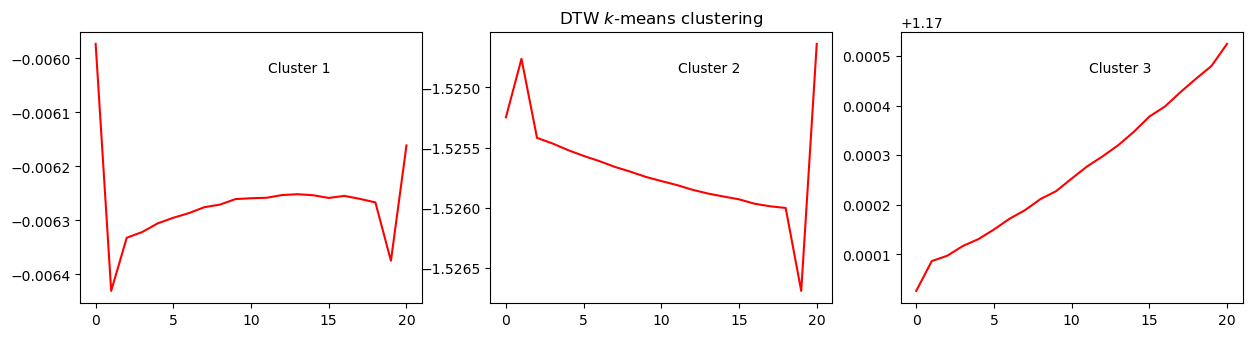

In [41]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

#### Euclidean K-means on zero-beginning data

In [42]:
# Sensor A Cal Window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_cal_window_zero)

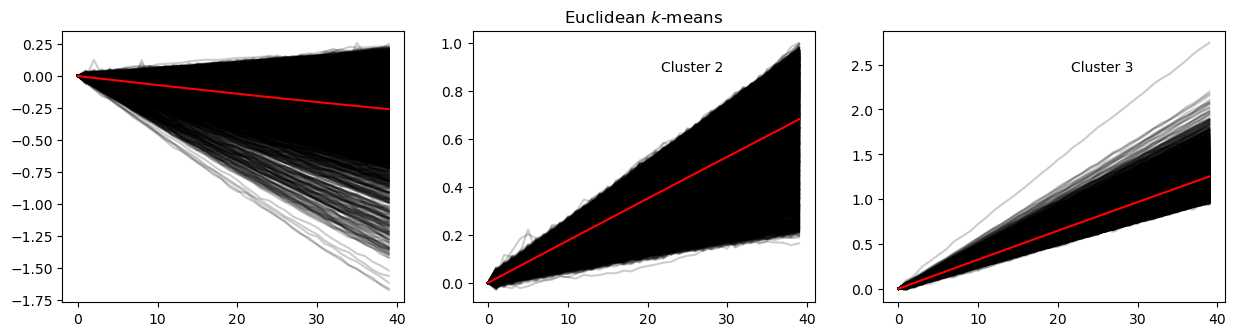

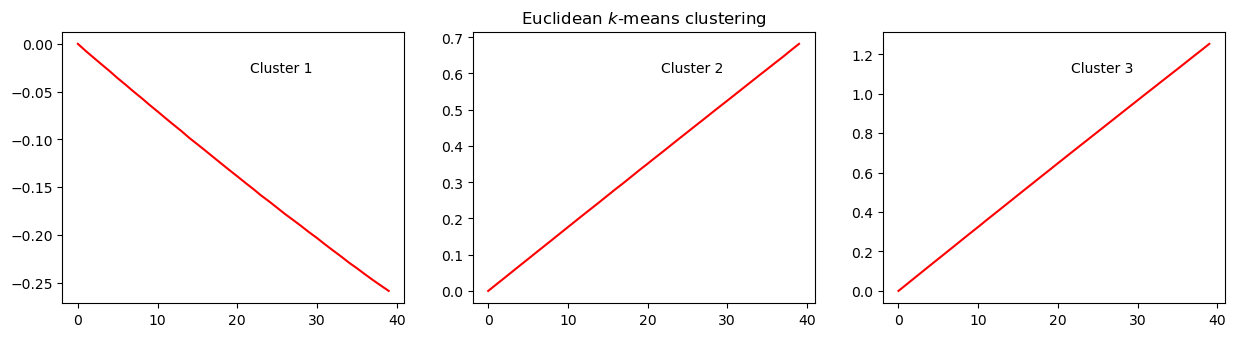

In [43]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_cal_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [44]:
# Sensor A Sample Window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(A_sample_window_zero)

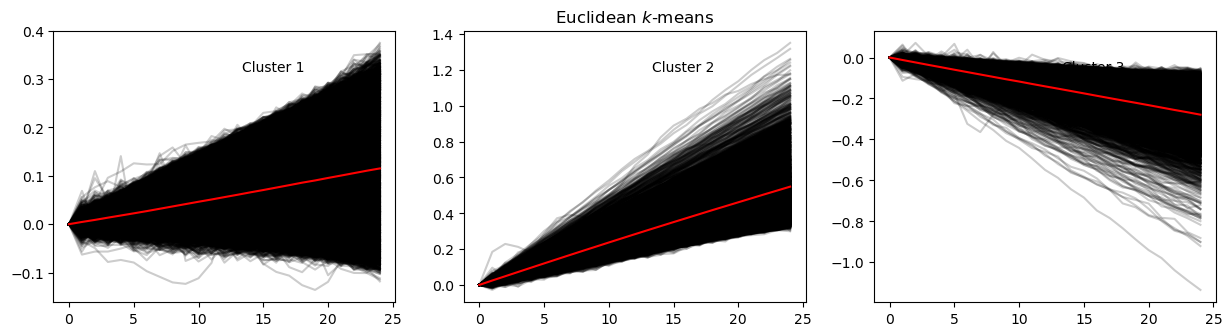

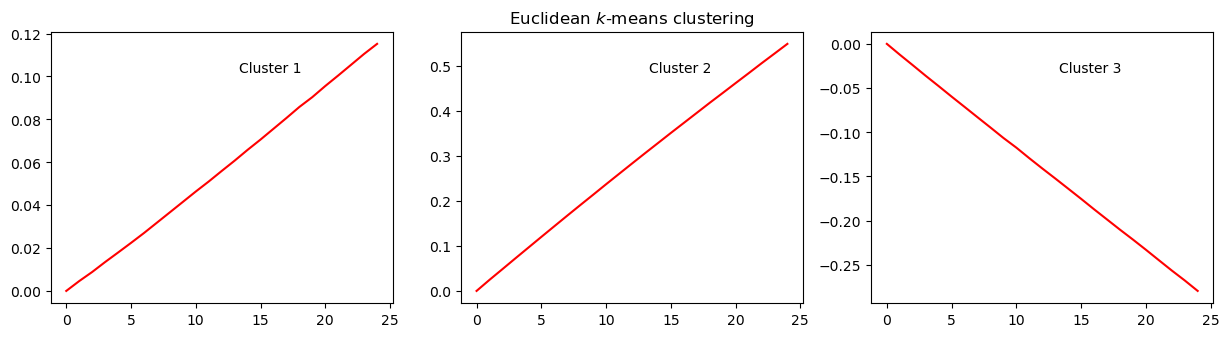

In [45]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_sample_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [46]:
# Sensor B Cal Window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_cal_window_zero)

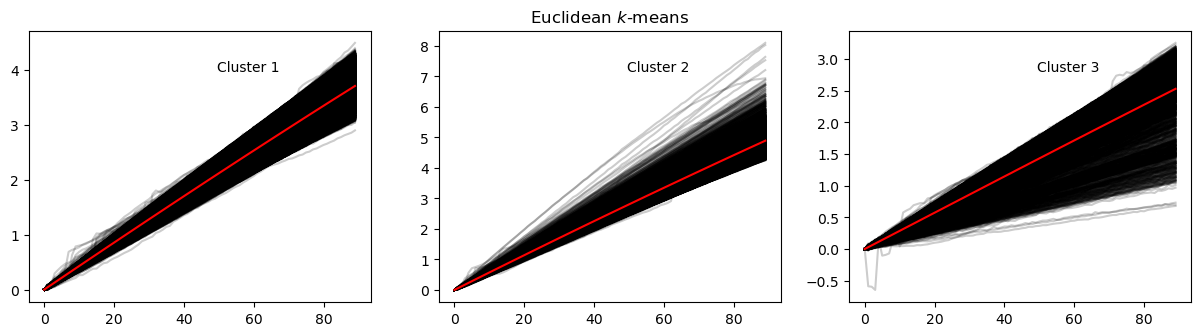

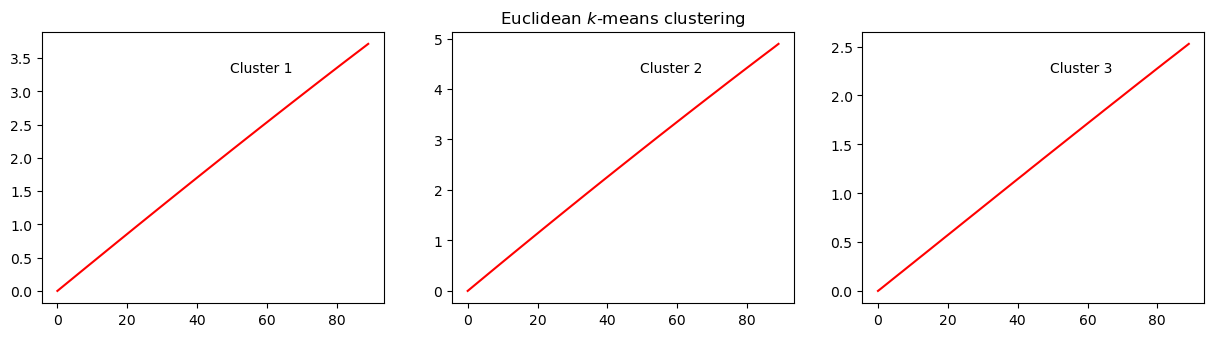

In [47]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_cal_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

In [48]:
# Sensor B Sample Window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred = model_euclidean.fit_predict(B_sample_window_zero)

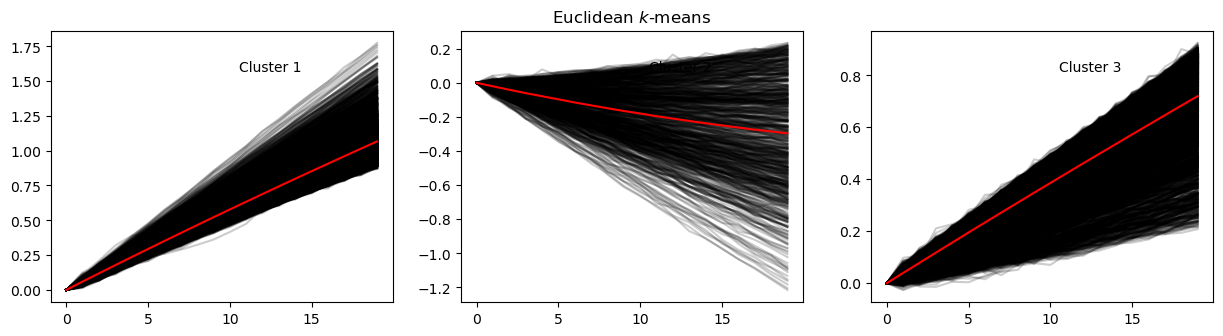

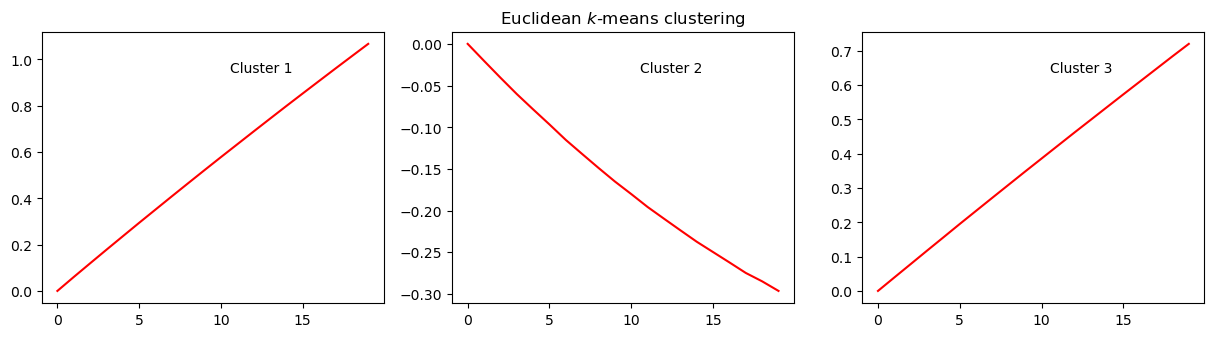

In [49]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_sample_window_zero[y_pred == yi].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    plt.plot(model_euclidean.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means clustering")

#### DTW K-means on zero-beginning data

In [50]:
# Sensor A cal Window
data = A_cal_window_zero.values.reshape(A_cal_window_zero.values.shape[0], A_cal_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

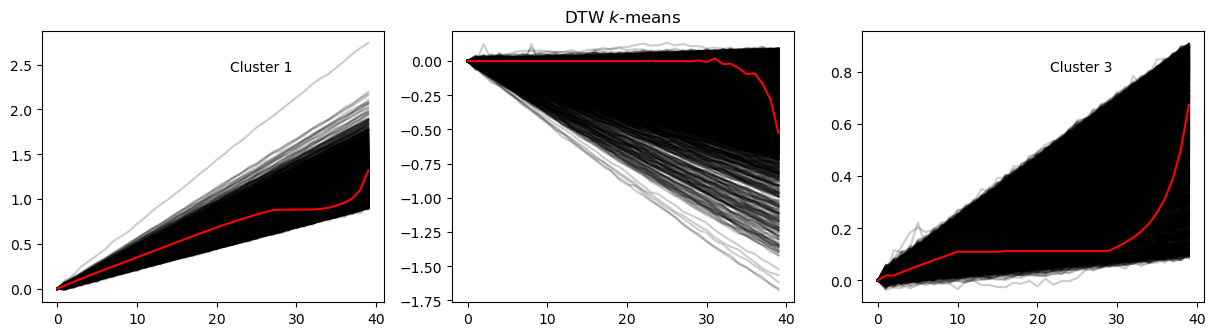

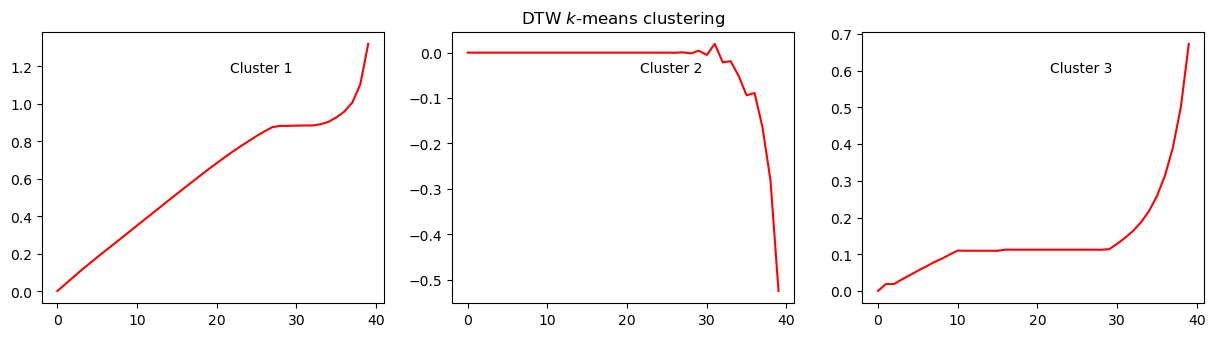

In [51]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [52]:
# Sensor A sample Window
data = A_sample_window_zero.values.reshape(A_sample_window_zero.values.shape[0], A_sample_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

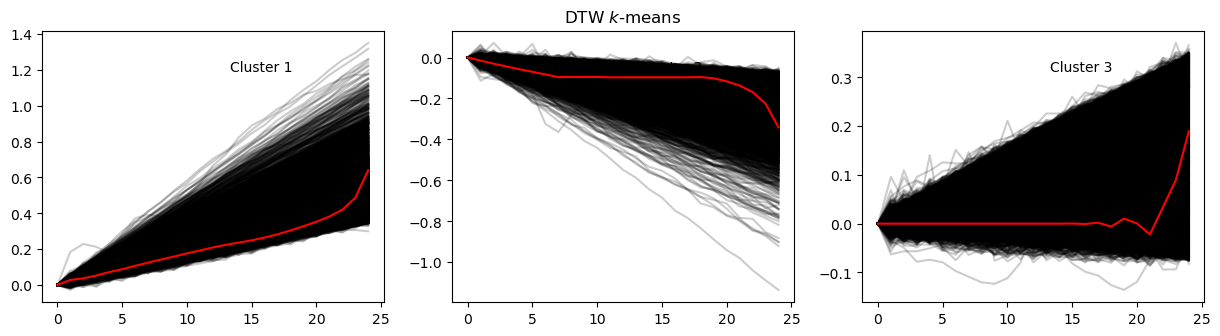

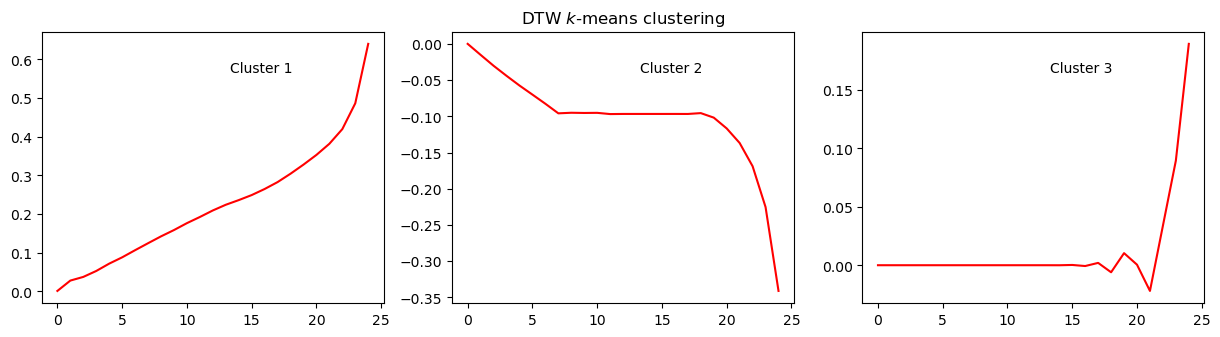

In [53]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [54]:
# Sensor B cal Window
data = B_cal_window_zero.values.reshape(B_cal_window_zero.values.shape[0], B_cal_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

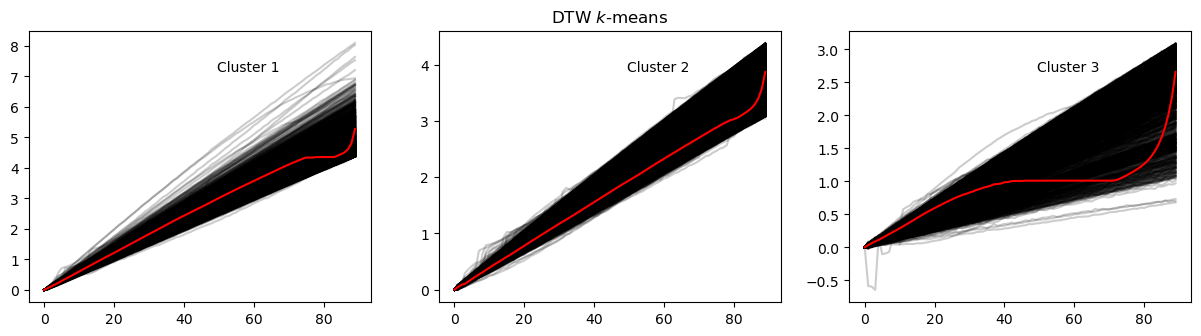

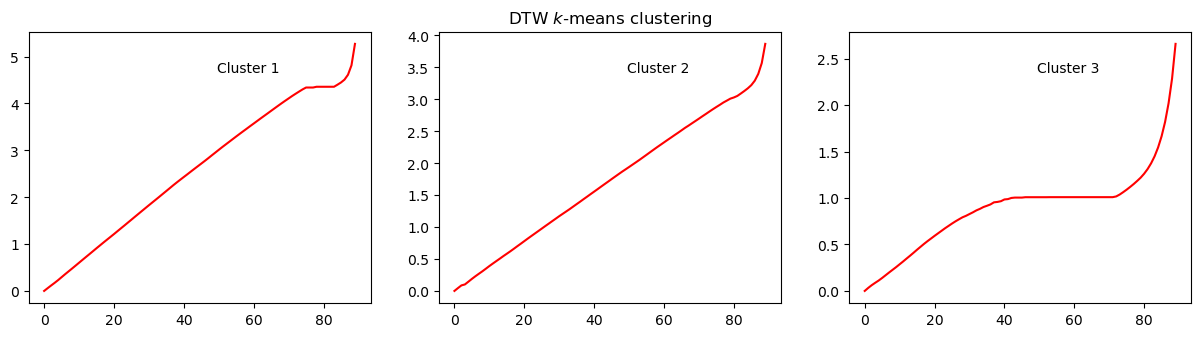

In [55]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [56]:
# Sensor B sample Window
data = B_sample_window_zero.values.reshape(B_sample_window_zero.values.shape[0], B_sample_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
model_dtw.fit(data)
y_pred_dtw = model_dtw.fit_predict(data)

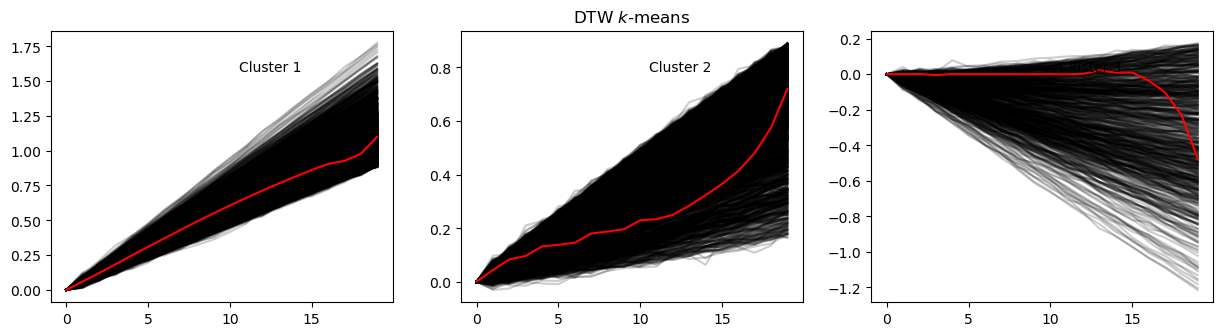

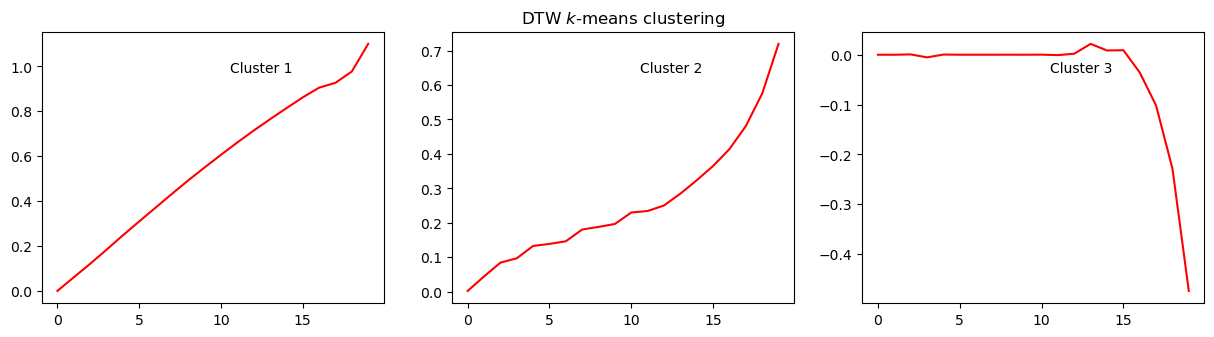

In [57]:
# Plotting
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for xx in data[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means")

plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    # for xx in data[y_pred_dtw == yi]:
    #     plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model_dtw.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DTW $k$-means clustering")

In [58]:
# Plot for sensor A cal window
import altair as alt

model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred_euclid = model_euclidean.fit_predict(A_cal_window_zero)
df = A_cal_window_zero.reset_index()
df['label'] = y_pred_euclid
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

alt.VConcatChart(...)

In [59]:
# Visulization Function for each cluster
def process_cluster(cluster_label, df, df2, windowType):
    cluster = df2[df2['label'] == cluster_label][['TestID', 'Systembi']]

    # Filtering and merging data for System 1
    cluster_data_s1 = pd.merge(cluster[cluster['Systembi'] == 'System 1']['TestID'], df, how='inner', on=['TestID']).drop("label", axis=1)
    cluster_data_s1.set_index('TestID', inplace=True)
    cluster_data_s1_mean = cluster_data_s1.mean(axis=0).to_frame().reset_index(drop=True)
    cluster_data_s1_mean.index.name = 'Time'
    cluster_data_s1_mean.columns = ['Mean']
    cluster_data_s1_mean.reset_index(inplace=True)
    cluster_data_s1_mean['Slope'] = np.gradient(cluster_data_s1_mean['Mean'], cluster_data_s1_mean['Time'])

    # Filtering and merging data for System 2
    cluster_data_s2 = pd.merge(cluster[cluster['Systembi'] != 'System 1']['TestID'], df, how='inner', on=['TestID']).drop("label", axis=1)
    cluster_data_s2.set_index('TestID', inplace=True)
    cluster_data_s2_mean = cluster_data_s2.mean(axis=0).to_frame().reset_index(drop=True)
    cluster_data_s2_mean.index.name = 'Time'
    cluster_data_s2_mean.columns = ['Mean']
    cluster_data_s2_mean.reset_index(inplace=True)
    cluster_data_s2_mean['Slope'] = np.gradient(cluster_data_s2_mean['Mean'], cluster_data_s2_mean['Time'])

    # Convert data to long format for Altair
    data_mean = pd.concat([
        cluster_data_s1_mean.assign(System='System 1'),
        cluster_data_s2_mean.assign(System='System 2')
    ])

    # Plotting the mean
    mean_chart = alt.Chart(data_mean).mark_line(point=True).encode(
        x='Time:Q',
        y='Mean:Q',
        color='System:N',
        tooltip=['Time', 'Mean', 'System']
    ).properties(
        title=f'Average Time Series in {windowType} Window - Cluster {cluster_label + 1}'
    )

    # Plotting the slope
    slope_chart = alt.Chart(data_mean).mark_line(point=True).encode(
        x='Time:Q',
        y=alt.Y('Slope:Q', scale=alt.Scale(domain=[min(data_mean['Slope']), max(data_mean['Slope'])])),
        color='System:N',
        tooltip=['Time', 'Slope', 'System']
    ).properties(
        title=f'Slope of Average Time Series in {windowType} Window - Cluster {cluster_label + 1}'
    )

    # Combine the charts horizontally
    combined_chart = alt.hconcat(mean_chart, slope_chart).resolve_scale(
        y='independent'
    )

    combined_chart.display()

In [60]:
# Average Time Series for sensor A Cal Window
windowType = 'Cal'
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2, windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [86]:
# Plot for sensor A sample window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred_euclid = model_euclidean.fit_predict(A_sample_window_zero)
df = A_sample_window_zero.reset_index()
df['label'] = y_pred_euclid
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

alt.VConcatChart(...)

In [87]:
# Average Time Series for sensor A Sample Window
windowType = "Sample"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [88]:
# Plot for sensor B cal window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred_euclid = model_euclidean.fit_predict(B_cal_window_zero)
df = B_cal_window_zero.reset_index()
df['label'] = y_pred_euclid
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

alt.VConcatChart(...)

In [89]:
# Average Time Series for sensor B Cal Window
windowType = "Cal"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [92]:
# Plot for sensor B sample window
model_euclidean = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
y_pred_euclid = model_euclidean.fit_predict(B_sample_window_zero)
df = B_sample_window_zero.reset_index()
df['label'] = y_pred_euclid
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

alt.VConcatChart(...)

In [95]:
# Average Time Series for sensor B Sample Window
windowType = "Sample"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [96]:
# Plot for sensor A cal window
data = A_cal_window_zero.values.reshape(A_cal_window_zero.values.shape[0], A_cal_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
y_pred_dtw = model_dtw.fit_predict(data)
df = A_cal_window_zero.reset_index()
df['label'] = y_pred_dtw
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

alt.VConcatChart(...)

In [98]:
# Average Time Series for sensor A Cal Window
windowType = "Cal"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [99]:
# Plot for sensor A sample window
data = A_sample_window_zero.values.reshape(A_sample_window_zero.values.shape[0], A_sample_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
y_pred_dtw = model_dtw.fit_predict(data)
df = A_sample_window_zero.reset_index()
df['label'] = y_pred_dtw
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

alt.VConcatChart(...)

In [100]:
# Average Time Series for sensor A Sample Window
windowType = "Sample"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [101]:
# Plot for sensor B cal window
data = B_cal_window_zero.values.reshape(B_cal_window_zero.values.shape[0], B_cal_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
y_pred_dtw = model_dtw.fit_predict(data)
df = B_cal_window_zero.reset_index()
df['label'] = y_pred_dtw
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

alt.VConcatChart(...)

In [102]:
# Average Time Series for sensor B Cal Window
windowType = "Cal"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

In [103]:
# Plot for sensor B sample window
data = B_sample_window_zero.values.reshape(B_sample_window_zero.values.shape[0], B_sample_window_zero.values.shape[1],1)
model_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw",max_iter=10,
                         random_state=0)
y_pred_dtw = model_dtw.fit_predict(data)
df = B_sample_window_zero.reset_index()
df['label'] = y_pred_dtw
df2 = pd.merge(keyByTestID, df[['label','TestID']], how='inner', on=['TestID'])
df2['Type'] = df2['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
df2['Systembi'] = df2['System'].apply(lambda x: 'System 1' if x=='System 1' else 'System 2')
   
cardage1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
cardage3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AgeOfCardInDaysAtTimeOfTest:Q', bin=alt.Bin(maxbins=20),title='Card Age'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

temperature1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
temperature3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('AmbientTemperature:Q', bin=alt.Bin(maxbins=20),title='Temperature'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

FluidType1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType2 = alt.Chart(df2[df2['label']==0]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
FluidType3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('FluidType:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

Type1 = alt.Chart(df2[df2['label']==1]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type2 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')
Type3 = alt.Chart(df2[df2['label']==2]).mark_bar().encode(
    x=alt.X('Type:N', title='Fluid Type'),
    y='count()'
).properties(width=150, height=150).facet(column='Systembi')

(cardage1 | cardage2 | cardage3) & (temperature1 | temperature2 | temperature3)  & (FluidType1 | FluidType2 | FluidType3)

alt.VConcatChart(...)

In [105]:
# Average Time Series for sensor B Sample Window
windowType = "Sample"
for cluster_label in [0, 1, 2]:
    process_cluster(cluster_label, df, df2,windowType)

alt.HConcatChart(...)

alt.HConcatChart(...)

alt.HConcatChart(...)

### Hierarchical clustering by sensor values

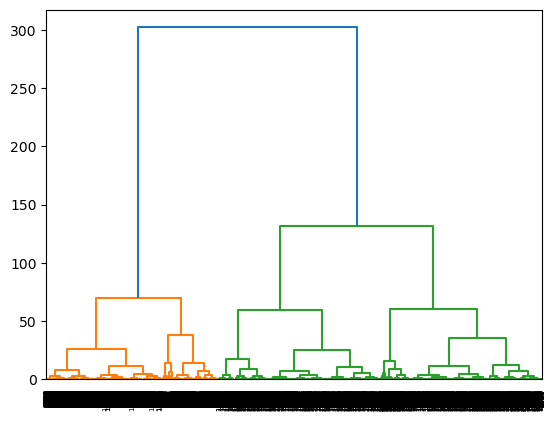

In [109]:
# sensorA calibration window
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
A_cal_linkage = linkage(A_cal_window_zero, method='ward', metric='euclidean')
dendrogram(A_cal_linkage)
plt.show()

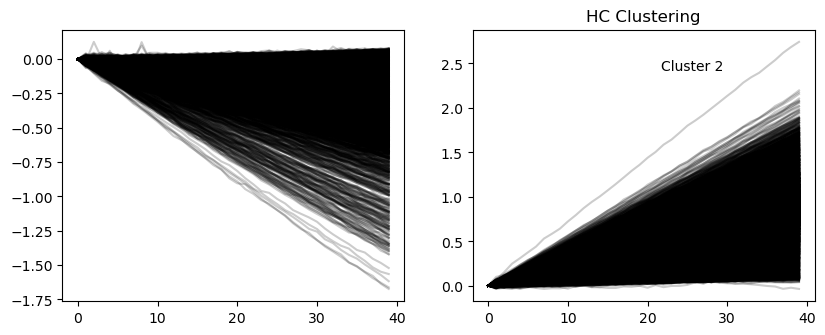

In [132]:
# Plotting
y_pred = fcluster(A_cal_linkage, 200, criterion='distance')
n_clusters = len(np.unique(y_pred))
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_cal_window_zero[y_pred == yi+1].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("HC Clustering")

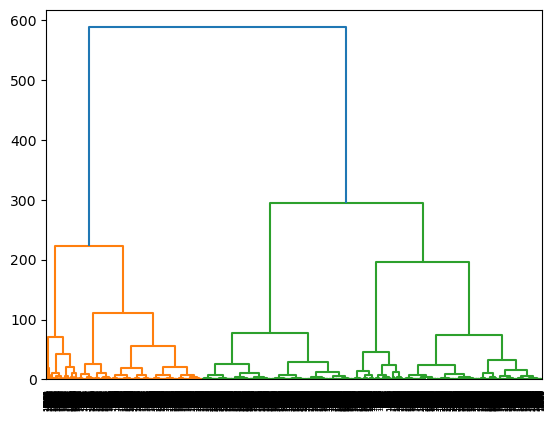

In [65]:
# sensorA sample window
A_sample_linkage = linkage(A_sample_window_zero, method='ward', metric='euclidean')
dendrogram(A_sample_linkage)
plt.show()

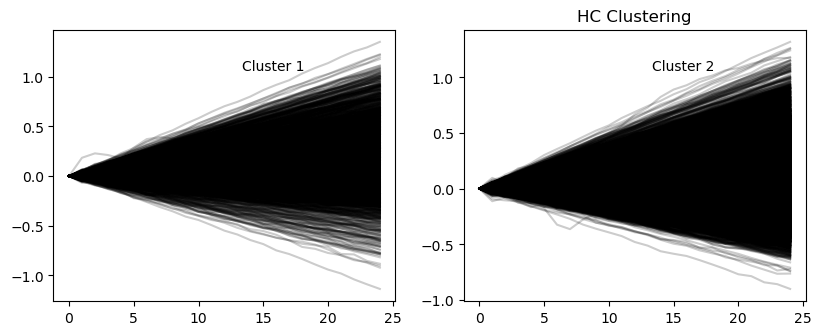

In [133]:
# Plotting
y_pred = fcluster(A_sample_linkage, 400, criterion='distance')
n_clusters = len(np.unique(y_pred))
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in A_sample_window_zero[y_pred == yi+1].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("HC Clustering")

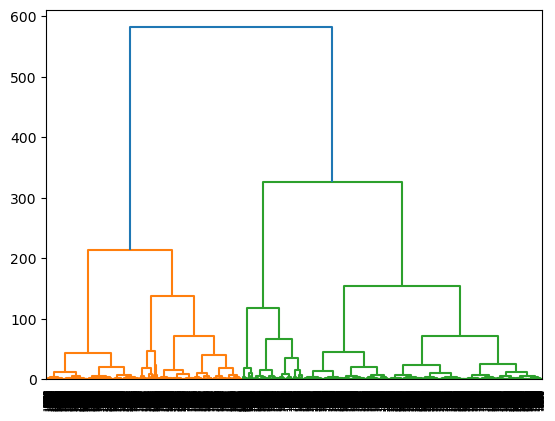

In [135]:
# sensorB cal window
B_cal_linkage = linkage(B_cal_window_zero, method='ward', metric='euclidean')
dendrogram(B_cal_linkage)
plt.show()

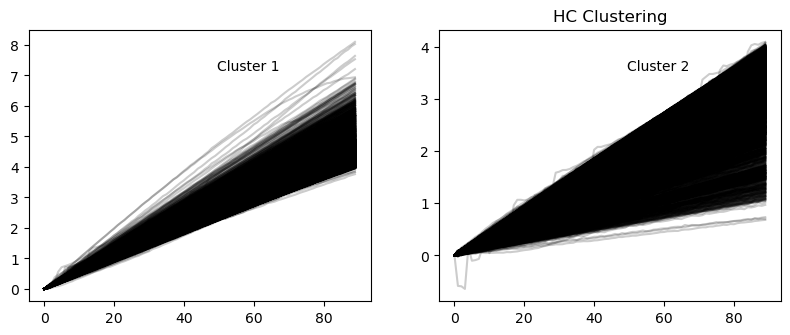

In [136]:
# Plotting
y_pred = fcluster(B_cal_linkage, 400, criterion='distance')
n_clusters = len(np.unique(y_pred))
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_cal_window_zero[y_pred == yi+1].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("HC Clustering")

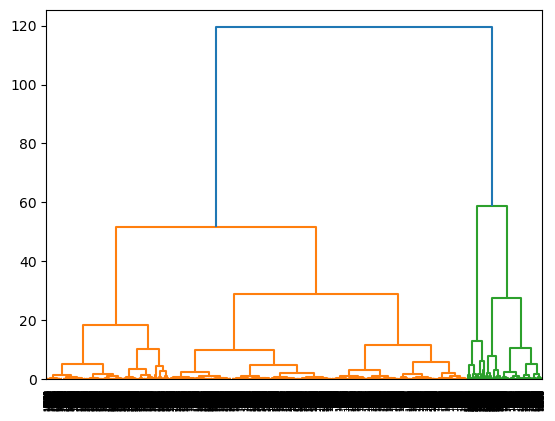

In [137]:
# sensorB sample window
B_sample_linkage = linkage(B_sample_window_zero, method='ward', metric='euclidean')
dendrogram(B_sample_linkage)
plt.show()

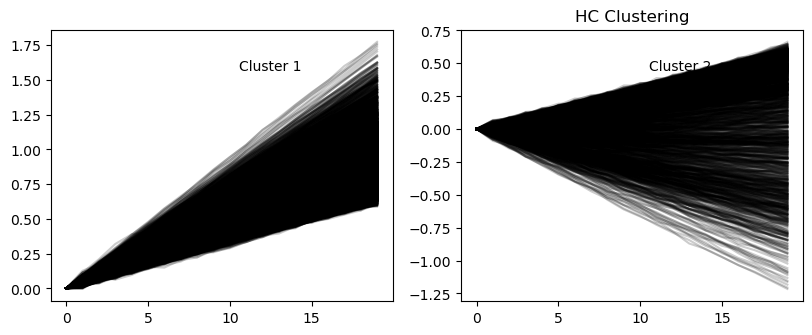

In [139]:
# Plotting
y_pred = fcluster(B_sample_linkage, 100, criterion='distance')
n_clusters = len(np.unique(y_pred))
plt.figure(figsize=(15, 12)) 
for yi in range(n_clusters):
    plt.subplot(3, 3, yi + 1)
    for index, row in B_sample_window_zero[y_pred == yi+1].iterrows():
        plt.plot(row.ravel(), "k-", alpha=.2)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("HC Clustering")

### Hierarchical Clustering by Attributes of All Test IDs

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_22194/469232650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['TypeEncoded'] = le.fit_transform(features['Type'])


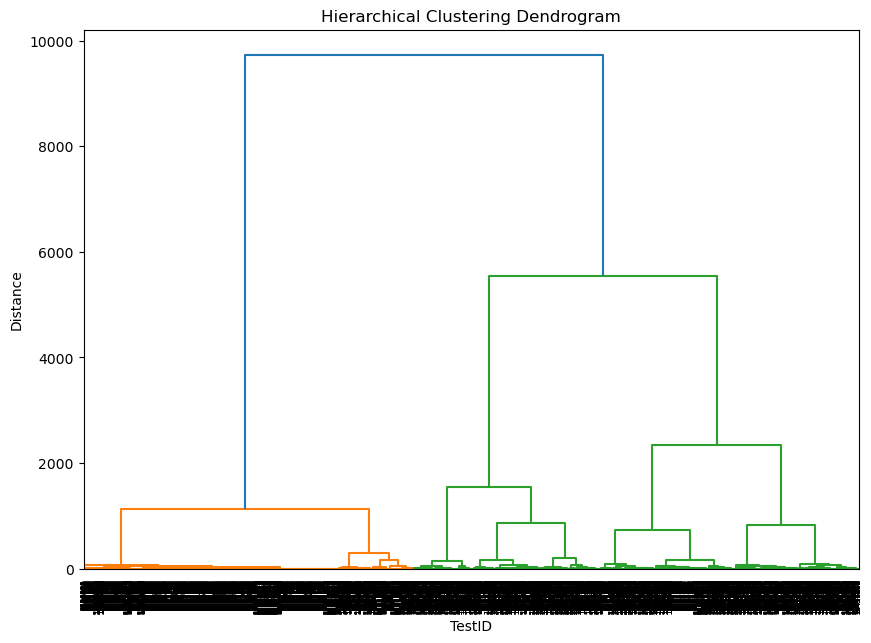

Cluster 1 DataFrame:
         TestID System_bi
0      12414200         1
1      12414201         1
2      12414202         1
3      12414203         1
4      12414204         1
...         ...       ...
10871   3518617         2
10872   3518618         2
10874   3518679         2
10876   3518708         2
10882   3518680         2

[4639 rows x 2 columns]

Cluster 2 DataFrame:
         TestID System_bi
674    12190911         1
679    12190942         1
684    12191039         1
687    12191055         1
694    12191114         1
...         ...       ...
10741   3543798         2
10742   3543799         2
10743   3543800         2
10745   3551882         2
10748   3558947         2

[2628 rows x 2 columns]

Cluster 3 DataFrame:
         TestID System_bi
671    12190908         1
672    12190909         1
673    12190910         1
675    12190938         1
676    12190939         1
...         ...       ...
10878   3518431         2
10879   3518461         2
10880   3518462         2
1

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_22194/469232650.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = clusters


In [68]:

# Concatenate the DataFrames vertically to have all test IDs for both systems in one dataframe
A_Combined = pd.concat([A1_Merged, A2_Merged], ignore_index=True)
A_Combined['Type'] = A_Combined['FluidType'].apply(lambda x: 'Eurotrol' if x.startswith('Eurotrol') else 'Blood')
A_Combined['System_bi'] = A_Combined['System'].apply(lambda x: '1' if x=='System 1' else '2')
# filter the important features for clustering
features = A_Combined[['TestID','System_bi','Type', 'AgeOfCardInDaysAtTimeOfTest']]
# encoding the category feature - sample fulid type for clustering
le = LabelEncoder()
features['TypeEncoded'] = le.fit_transform(features['Type'])
X = features[['TypeEncoded', 'AgeOfCardInDaysAtTimeOfTest']]
# Perform hierarchical clustering
Z = linkage(X, method='ward')
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=features['TestID'].values)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('TestID')
plt.ylabel('Distance')
plt.show()
max_d = 3000  # Maximum distance to cut the dendrogram (adjust as needed)
clusters = fcluster(Z, max_d, criterion='distance')
# Add cluster labels to the original data
features['Cluster'] = clusters
# Seprate tests into three clusters
cluster_1_HC = features[features['Cluster'] == 1][['TestID', 'System_bi']]
cluster_2_HC = features[features['Cluster'] == 2][['TestID', 'System_bi']]
cluster_3_HC = features[features['Cluster'] == 3][['TestID', 'System_bi']]
# Print the resulting DataFrames
print("Cluster 1 DataFrame:")
print(cluster_1_HC)
print("\nCluster 2 DataFrame:")
print(cluster_2_HC)
print("\nCluster 3 DataFrame:")
print(cluster_3_HC)

In [69]:
print(features['Cluster'].unique())

[1 3 2]


In [70]:
# Cluster by fluid type
alt.Chart(features).mark_bar().encode(x='Type',y='count()').properties(width=150,height=200).facet(column='Cluster',row='System_bi')

alt.FacetChart(...)

In [71]:
# Cluster by card age
alt.Chart(features).mark_boxplot().encode(x='Cluster',y='AgeOfCardInDaysAtTimeOfTest').properties(width=200,height=300).facet(column='System_bi')

alt.FacetChart(...)

### K - Means Clustering by Attributes of All Test IDs

         TestID System_bi      Type  AgeOfCardInDaysAtTimeOfTest  TypeEncoded  \
0      12414200         1  Eurotrol                            7            1   
1      12414201         1  Eurotrol                            7            1   
2      12414202         1  Eurotrol                            7            1   
3      12414203         1  Eurotrol                            7            1   
4      12414204         1  Eurotrol                            7            1   
...         ...       ...       ...                          ...          ...   
10879   3518461         2  Eurotrol                           76            1   
10880   3518462         2  Eurotrol                          125            1   
10881   3518621         2     Blood                          125            0   
10882   3518680         2     Blood                           41            0   
10883   3518682         2     Blood                          111            0   

       Cluster  
0         

/var/folders/vh/dw36swbx2939r11_2dkm6r4m0000gn/T/ipykernel_22194/1601744064.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['Cluster'] = kmeans.fit_predict(X)


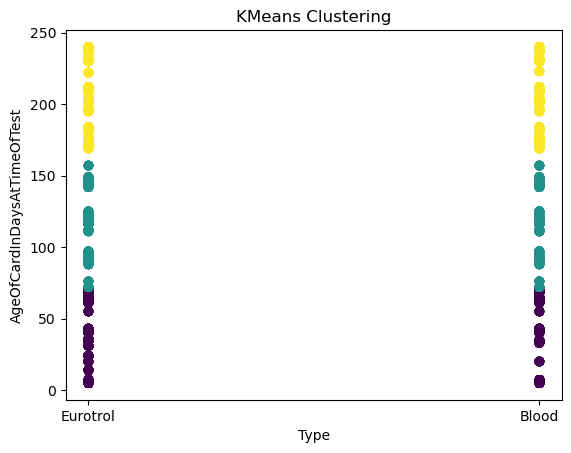

In [72]:
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model
features['Cluster'] = kmeans.fit_predict(X)

print(features)

# Plot the clusters
plt.scatter(features['Type'], features['AgeOfCardInDaysAtTimeOfTest'], c=features['Cluster'], cmap='viridis')
plt.xlabel('Type')
plt.ylabel('AgeOfCardInDaysAtTimeOfTest')
plt.title('KMeans Clustering')
plt.show()

In [73]:
print(features['Cluster'].unique())

[0 1 2]


In [74]:
# Seprate tests into three clusters
cluster_1_kmeans = features[features['Cluster'] == 0][['TestID', 'System_bi']]
cluster_2_kmeans = features[features['Cluster'] == 1][['TestID', 'System_bi']]
cluster_3_kmeans = features[features['Cluster'] == 2][['TestID', 'System_bi']]
# Print the resulting DataFrames
print("Cluster 1 DataFrame:")
print(cluster_1_kmeans)
print("\nCluster 2 DataFrame:")
print(cluster_2_kmeans)
print("\nCluster 3 DataFrame:")
print(cluster_3_kmeans)

Cluster 1 DataFrame:
         TestID System_bi
0      12414200         1
1      12414201         1
2      12414202         1
3      12414203         1
4      12414204         1
...         ...       ...
10871   3518617         2
10872   3518618         2
10874   3518679         2
10876   3518708         2
10882   3518680         2

[5673 rows x 2 columns]

Cluster 2 DataFrame:
         TestID System_bi
671    12190908         1
672    12190909         1
673    12190910         1
676    12190939         1
677    12190940         1
...         ...       ...
10878   3518431         2
10879   3518461         2
10880   3518462         2
10881   3518621         2
10883   3518682         2

[2583 rows x 2 columns]

Cluster 3 DataFrame:
         TestID System_bi
674    12190911         1
679    12190942         1
684    12191039         1
687    12191055         1
694    12191114         1
...         ...       ...
10741   3543798         2
10742   3543799         2
10743   3543800         2
1

In [75]:
# Cluster by fluid type
alt.Chart(features).mark_bar().encode(x='Type',y='count()').properties(width=150,height=200).facet(column='Cluster',row='System_bi')

alt.FacetChart(...)

In [76]:
# Cluster by card age
alt.Chart(features).mark_boxplot().encode(x='Cluster',y='AgeOfCardInDaysAtTimeOfTest').properties(width=200,height=300).facet(column='System_bi')

alt.FacetChart(...)

#### Compare the clusters between HC and Kmeans

In [77]:
cluster_2_HC[cluster_2_HC['TestID'].isin(cluster_3_kmeans['TestID']) == False]

Empty DataFrame
Columns: [TestID, System_bi]
Index: []

In [78]:
cluster_3_HC[cluster_3_HC['TestID'].isin(cluster_2_kmeans['TestID']) == False]

TestID System_bi
675    12190938         1
680    12191035         1
688    12191056         1
690    12191109         1
698    12191140         1
...         ...       ...
10713   3551840         2
10714   3551841         2
10715   3551842         2
10728   3543758         2
10744   3551835         2

[1034 rows x 2 columns]

In [79]:
cluster_1_HC[cluster_1_HC['TestID'].isin(cluster_1_kmeans['TestID'])==False]

Empty DataFrame
Columns: [TestID, System_bi]
Index: []

##### Use HC clustering to draw window curves 

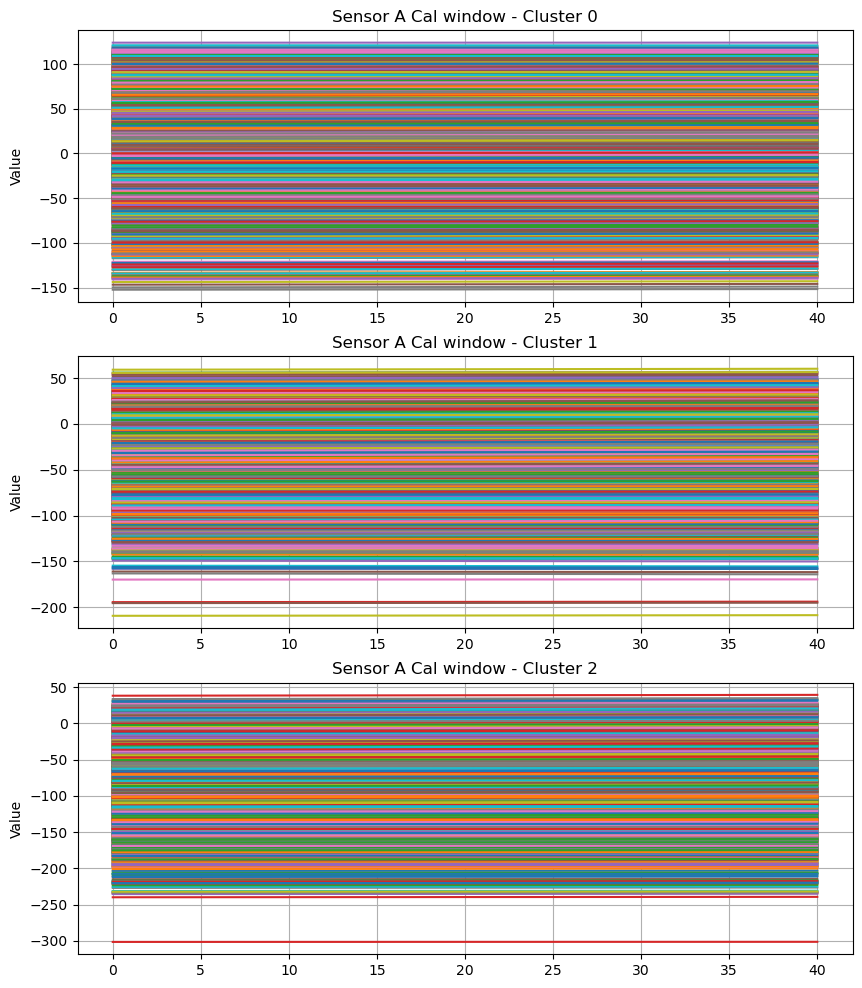

In [80]:
## Sensor A - Cal window (system 1 vs system 2)
A_cal_window_cluster = pd.merge(pd.concat([A1_cal_window, A2_cal_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 

fig, axs = plt.subplots(3, 1, figsize=(10, 12))
# Plotting time series curves in subplots
for cluster_label, ax in zip(A_cal_window_cluster['Cluster'].unique(), axs):
    cluster_data = A_cal_window_cluster[A_cal_window_cluster['Cluster'] == cluster_label].drop(['Cluster','TestID','System_bi'], axis=1)
    for index, row in cluster_data.iterrows():
        ax.plot(row)

    ax.set_ylabel('Value')
    ax.set_title(f'Sensor A Cal window - Cluster {cluster_label}')
    ax.grid(True)

plt.show()

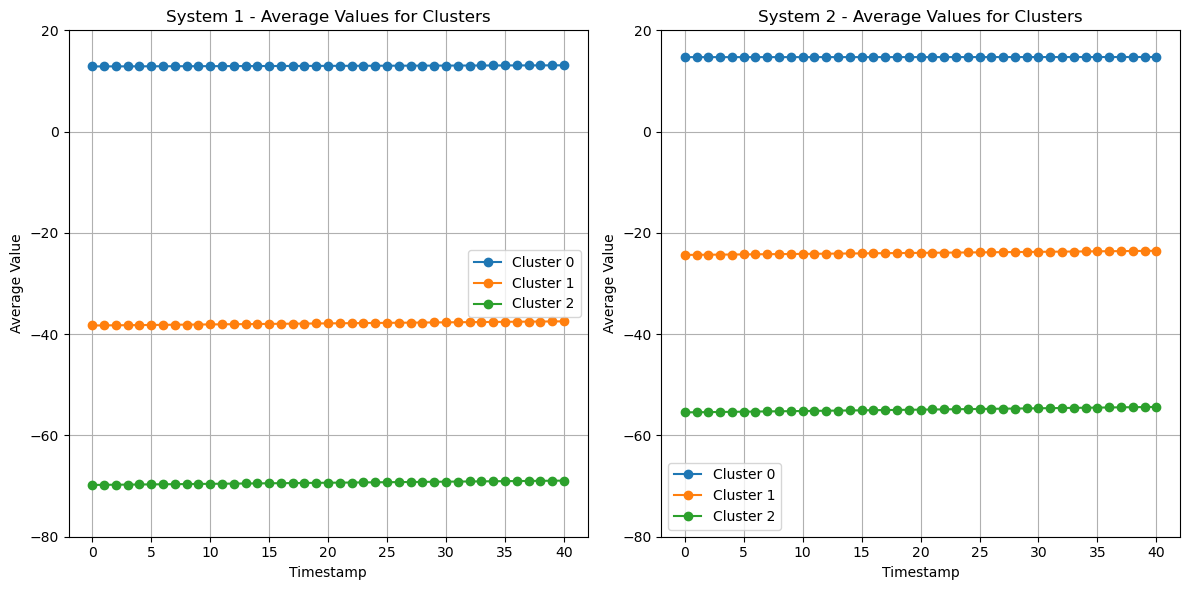

In [81]:
## Sensor A - Cal window (system 1 vs system 2) average value
A_cal_window_cluster = pd.merge(pd.concat([A1_cal_window, A2_cal_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 
df = A_cal_window_cluster
avg_values = df.groupby(['System_bi', 'Cluster']).mean().reset_index()

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6))

# Plotting average values in subplots for System 1
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '1')]
    axs1[0].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[0].set_ylim(-80, 20)

axs1[0].set_xlabel('Timestamp')
axs1[0].set_ylabel('Average Value')
axs1[0].set_title('System 1 - Average Values for Clusters')
axs1[0].legend()
axs1[0].grid(True)

# Plotting average values in subplots for System 2
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '2')]
    axs1[1].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-80, 20)

axs1[1].set_xlabel('Timestamp')
axs1[1].set_ylabel('Average Value')
axs1[1].set_title('System 2 - Average Values for Clusters')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()
plt.show()


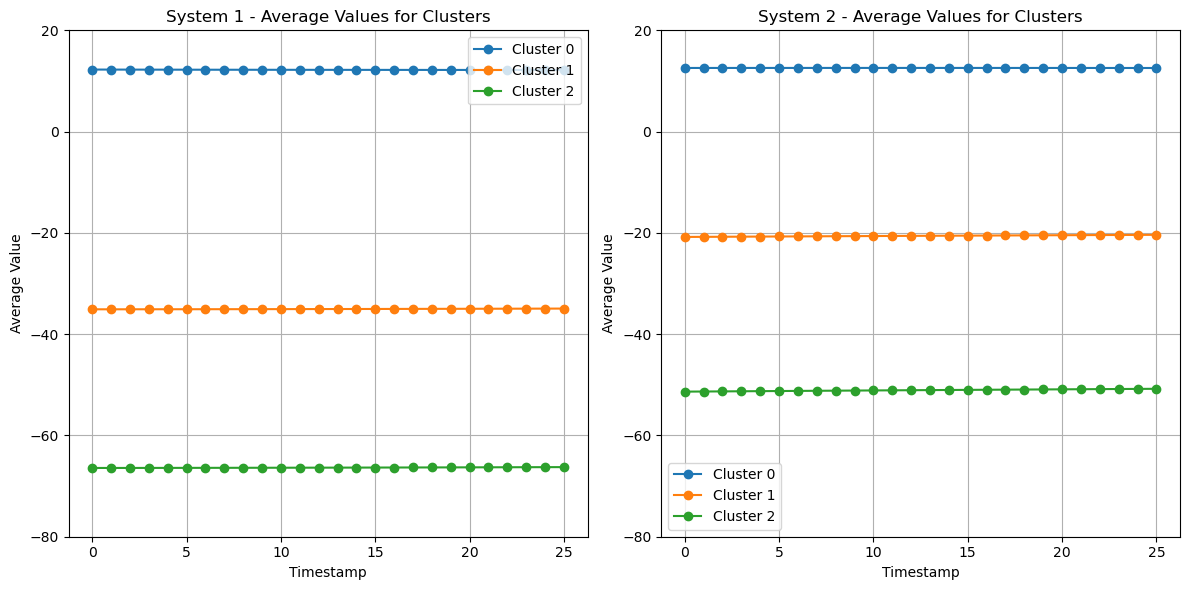

In [82]:
## Sensor A - sample window (system 1 vs system 2) average value
A_sample_window_cluster = pd.merge(pd.concat([A1_sample_window, A2_sample_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 
df = A_sample_window_cluster
avg_values = df.groupby(['System_bi', 'Cluster']).mean().reset_index()

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6))

# Plotting average values in subplots for System 1
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '1')]
    axs1[0].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[0].set_ylim(-80, 20)

axs1[0].set_xlabel('Timestamp')
axs1[0].set_ylabel('Average Value')
axs1[0].set_title('System 1 - Average Values for Clusters')
axs1[0].legend()
axs1[0].grid(True)

# Plotting average values in subplots for System 2
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '2')]
    axs1[1].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-80, 20)

axs1[1].set_xlabel('Timestamp')
axs1[1].set_ylabel('Average Value')
axs1[1].set_title('System 2 - Average Values for Clusters')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()
plt.show()


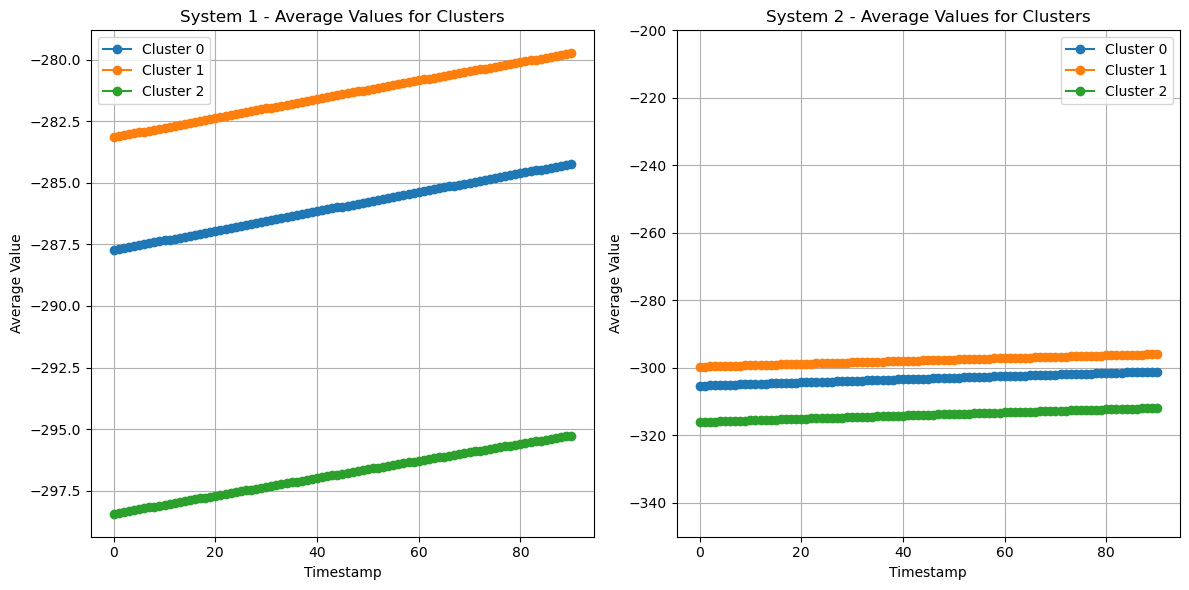

In [83]:
## Sensor B - cal window (system 1 vs system 2) average value
B_cal_window_cluster = pd.merge(pd.concat([B1_cal_window, B2_cal_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 
df = B_cal_window_cluster
avg_values = df.groupby(['System_bi', 'Cluster']).mean().reset_index()

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6))

# Plotting average values in subplots for System 1
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '1')]
    axs1[0].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-350, -200)

axs1[0].set_xlabel('Timestamp')
axs1[0].set_ylabel('Average Value')
axs1[0].set_title('System 1 - Average Values for Clusters')
axs1[0].legend()
axs1[0].grid(True)

# Plotting average values in subplots for System 2
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '2')]
    axs1[1].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-350, -200)

axs1[1].set_xlabel('Timestamp')
axs1[1].set_ylabel('Average Value')
axs1[1].set_title('System 2 - Average Values for Clusters')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()
plt.show()

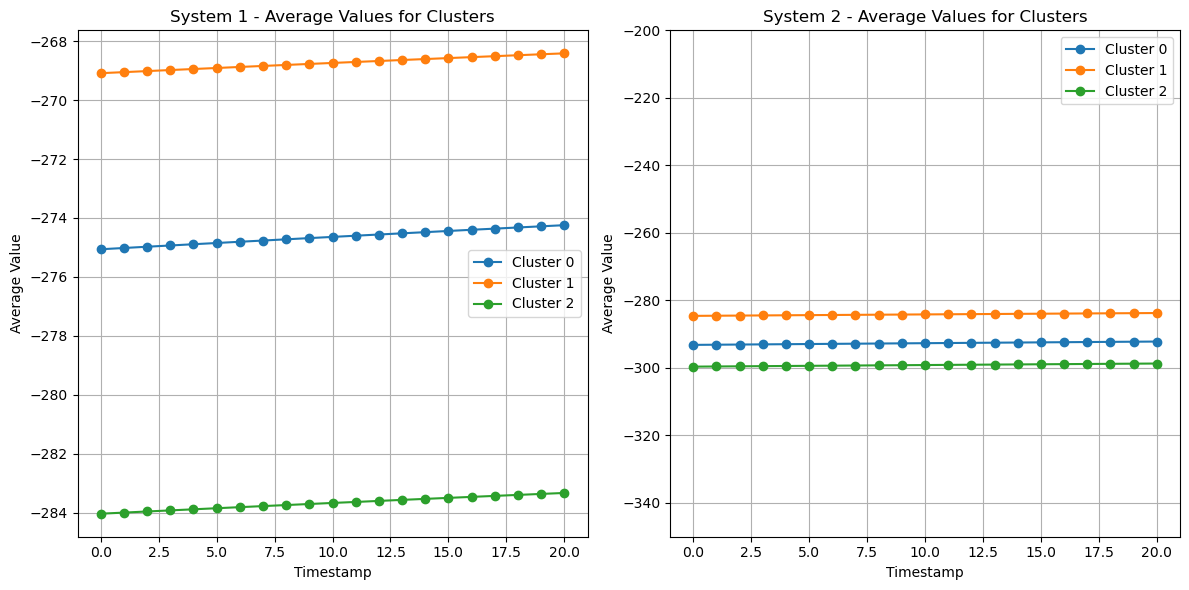

In [84]:
## Sensor B - sample window (system 1 vs system 2) average value
B_sample_window_cluster = pd.merge(pd.concat([B1_sample_window, B2_sample_window]),features[['TestID','Cluster','System_bi']],how='inner', on=['TestID']) 
df = B_sample_window_cluster
avg_values = df.groupby(['System_bi', 'Cluster']).mean().reset_index()

fig1, axs1 = plt.subplots(1, 2, figsize=(12, 6))
ymax = avg_values.columns[3:].max()
# Plotting average values in subplots for System 1
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '1')]
    axs1[0].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-350, -200)

axs1[0].set_xlabel('Timestamp')
axs1[0].set_ylabel('Average Value')
axs1[0].set_title('System 1 - Average Values for Clusters')
axs1[0].legend()
axs1[0].grid(True)

# Plotting average values in subplots for System 2
for cluster_label in avg_values[avg_values['System_bi'] == '1']['Cluster'].unique():
    cluster_data = avg_values[(avg_values['Cluster'] == cluster_label) & (avg_values['System_bi'] == '2')]
    axs1[1].plot(cluster_data.columns[3:], cluster_data.iloc[0, 3:], label=f'Cluster {cluster_label}', marker='o')
    axs1[1].set_ylim(-350, -200)

axs1[1].set_xlabel('Timestamp')
axs1[1].set_ylabel('Average Value')
axs1[1].set_title('System 2 - Average Values for Clusters')
axs1[1].legend()
axs1[1].grid(True)

plt.tight_layout()
plt.show()